In [293]:
######################################
### loading in necessary libraries ###
######################################

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import ticker
from matplotlib.colors import PowerNorm, LogNorm
from scipy.stats import norm
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
import pandas as pd

from matplotlib.colors import LogNorm
from matplotlib.patches import Circle
from ipywidgets import interactive
# Enable interactive plots
#%matplotlib notebook
#%matplotlib inline

import uproot
import awkward as ak
import os

In [294]:
number_of_fragment = 2 #(1 or 2)
symmetrize_electron = True
symmetrize_ion = False
write_momentum_to_file = True
manual_offset = False

m1 = 45
m2 = 46
q1 = 1
q2 = 1
# nitrogen 14
# helium 4
# HCOOH 46
#HCOOH dimer

ion1_tof = [5500, 7000]
ion2_tof = [6500, 8250]
ion_tof = [5500, 8250]
ion_xy_edge = [-40, 40]
#Helium -2, 2
#other experiment 40
elec_tof = [38, 72]
#nitrogen N+ N+ 2000-4000, 3000-6000
#HCOOH  HCOOH+ HCOOH+ 5500-7000, 6500-8250
#HCOOH  H+ COOH+ 700-1400, 6250-7000
#HCOOH  OH+ HCO+ 3000 5000 4500 6500
#Helium He+ 1950 2010

#ion xy He -2, 2

#He 40eV
#infile_name = r"G:\20231112_LBNL_COLTRIMS\202308_ALS_APR_2023_HCOOH Analysis\CALBIRATION\He\he_40p59ev_horiz_11p0vcm_9p8g_a_001.root"
#N2
#infile_name = r"G:\20231112_LBNL_COLTRIMS\202308_ALS_APR_2023_HCOOH Analysis\CALBIRATION\N2\1_24\n2_56p0ev_horiz_11p0vcm_9p8g_a.00005_005.root"
#HCOOH dimer
#infile_name = r"D:\20231112_LBNL_COLTRIMS\202308_ALS_APR_2023_HCOOH Analysis\DATA\HCOOH\20240123_HCOOH_dimer\HCOOH_56p0ev_horiz_11p0vcm_9p8g _c.0004s_004.root"
#HCOOD dimer
#infile_name = r"D:\20231112_LBNL_COLTRIMS\202308_ALS_APR_2023_HCOOH Analysis\DATA\HCOOD\20240206_HCOOD_Dimer\HCOOD_56p0ev_horiz_11p0vcm_9p8g _c.0003s_001.root"
#HCO-OH
#infile_name = r"G:\20231112_LBNL_COLTRIMS\202308_ALS_APR_2023_HCOOH Analysis\DATA\HCOOH\20240126_H2O_CO\HCOOH_56p0ev_horiz_11p0vcm_9p8g _b.0001s_002.root"
#HCO-OH
#infile_name = r"D:\20231112_LBNL_COLTRIMS\202308_ALS_APR_2023_HCOOH Analysis\DATA\HCOOH\20240202_H_HCOO\HCOOH_56p0ev_horiz_11p0vcm_9p8g _a.0000s.root"

infile_name = r"G:\20231112_LBNL_COLTRIMS\202308_ALS_APR_2023_HCOOH Analysis\DATA\HCOOH\20240123_HCOOH_dimer\HCOOH_56p0ev_horiz_11p0vcm_9p8g _c.0005s_005.root"
output_file_name = "all_data_45_46.csv"
#he30eV, electron KE 6
#he46eV, electron KE 22
#he52eV, electron KE 28
#manual offset
if manual_offset:
    i_px0_offset = 0
    i_py0_offset = 2
    i_pz0_offset = -6
    i_px1_offset = 0
    i_py1_offset = 7
    i_pz1_offset = -6
else:
    i_px0_offset = 0
    i_py0_offset = 0
    i_pz0_offset = 0
    i_px1_offset = 0
    i_py1_offset = 0
    i_pz1_offset = 0
#HCOOH Dimer 0 2 -6 0 7 -6

In [295]:
PAU = 1.99285e-24           # Momentum in AU
MASSAU = 1822.888           # Mass in AU
VAU = 2.1877e6              # Velocity in AUs
EVAU = 27.2114              # eV in AU
EFIELDAU = 0.00805          # Electric field (V/cm) in AU
PI = 3.14159265             # PI
MEKG = 9.1093897e-31        # Electron Mass in Kg
MUKG = 1.66053886e-27       # u in Kg
COULOMB = 1.60217733e-19    # Elementary charge
Kg_over_AMU = 1.660538782e-27
C_over_au = 1.602176487e-19

In [296]:
e1tof_left_edge = elec_tof[0]
e1tof_right_edge = elec_tof[1]
r1tof_left_edge = ion1_tof[0]
r1tof_right_edge = ion1_tof[1]

e2tof_left_edge = elec_tof[0]
e2tof_right_edge = elec_tof[1]
r2tof_left_edge = ion2_tof[0]
r2tof_right_edge = ion2_tof[1]

r1x_left_edge = ion_xy_edge[0]
r1x_right_edge= ion_xy_edge[1]
r1y_left_edge = ion_xy_edge[0]
r1y_right_edge= ion_xy_edge[1]

r2x_left_edge = ion_xy_edge[0]
r2x_right_edge= ion_xy_edge[1]
r2y_left_edge = ion_xy_edge[0]
r2y_right_edge= ion_xy_edge[1]

if symmetrize_ion:
    r1tof_left_edge = ion1_tof[0]
    r1tof_right_edge = ion2_tof[1]
    r2tof_left_edge = ion1_tof[0]
    r2tof_right_edge = ion2_tof[1]

B_field_ns = 37.2433
Bfield_clockwise = True

e_acc1mm = 70.0750 #mm 44.0
e_acc2mm = 138.1208 #mm 11.1
e_acc3mm = 5
e_Efield1_Vpcm = 11.0575#/7.00750 #11.2/4.4
e_Efield2_Vpcm = 0 #300/1.11
e_Efield3_Vpcm = 745#/0.5

l_acc1mm = 44 #mm 44.0
l_acc2mm = 11.1 #mm 11.1
l_acc3mm = 0
l_Efield1_Vpcm = 11.1 #11.2/4.4
l_Efield2_Vpcm = 300 #300/1.11
l_Efield3_Vpcm = 0


In [297]:

root_file = uproot.open(infile_name)

l_key_name = root_file.keys()
filtered_variables = [var for var in l_key_name if 'Data' in var]
tree_name = filtered_variables[0]
print(tree_name)

branch = root_file[tree_name]["e1tof"]

e1tof = ak.to_numpy(root_file[tree_name]["e1tof"].array())
e1x = ak.to_numpy(root_file[tree_name]["e1x"].array())
e1y = ak.to_numpy(root_file[tree_name]["e1y"].array())
e2tof = ak.to_numpy(root_file[tree_name]["e2tof"].array())
e2x = ak.to_numpy(root_file[tree_name]["e2x"].array())
e2y = ak.to_numpy(root_file[tree_name]["e2y"].array())
r1tof = ak.to_numpy(root_file[tree_name]["r1tof"].array())
r1x = ak.to_numpy(root_file[tree_name]["r1x"].array())
r1y = ak.to_numpy(root_file[tree_name]["r1y"].array())
r2tof = ak.to_numpy(root_file[tree_name]["r2tof"].array())
r2x = ak.to_numpy(root_file[tree_name]["r2x"].array())
r2y = ak.to_numpy(root_file[tree_name]["r2y"].array())
bunchmarker = ak.to_numpy(root_file[tree_name]["bunchmarker"].array())
totaltof = np.concatenate((r1tof, r2tof), axis = 0)

root_file.close()
print(len(r1tof))
print(len(r2tof))
print(len(totaltof))

Data;2
489518
489518
979036


In [298]:
# Extracting relevant information from the input file name
folder_path, file_name = os.path.split(infile_name)
file_name_without_extension = os.path.splitext(file_name)[0]

# Create the folder if it doesn't exist
output_folder = os.path.join(folder_path, file_name_without_extension)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

folder_path = output_folder

In [299]:
if number_of_fragment == 1:
    e2tof = e1tof
    e2x = e1x
    e2y = e1y
    r2tof = r1tof
    r2x = r1x
    r2y = r1y

In [300]:
if symmetrize_electron & (number_of_fragment == 2):
    e_swap_mask_1 = np.random.randint(2, size=len(e1tof))
 #   e_swap_mask_2 = 1 - e_swap_mask_1 #create array that's the opposite of the top one

    # Assuming e_swap_mask_1, e1tof, and e2tof are your existing arrays
    e1tof_new = np.where(e_swap_mask_1 == 1, e2tof, e1tof)
    e2tof_new = np.where(e_swap_mask_1 == 1, e1tof, e2tof)
    e1x_new = np.where(e_swap_mask_1 == 1, e2x, e1x)
    e2x_new = np.where(e_swap_mask_1 == 1, e1x, e2x)
    e1y_new = np.where(e_swap_mask_1 == 1, e2y, e1y)
    e2y_new = np.where(e_swap_mask_1 == 1, e1y, e2y)

    e1tof_old = e1tof
    e2tof_old = e2tof
    e1x_old = e1x
    e2x_old = e2x
    e1y_old = e1y
    e2y_old = e2y

    e1tof = e1tof_new
    e2tof = e2tof_new
    e1x = e1x_new
    e2x = e2x_new
    e1y = e1y_new
    e2y = e2y_new

# # Now, e1tof_new and e2tof_new contain the swapped values based on the mask e_swap_mask_1


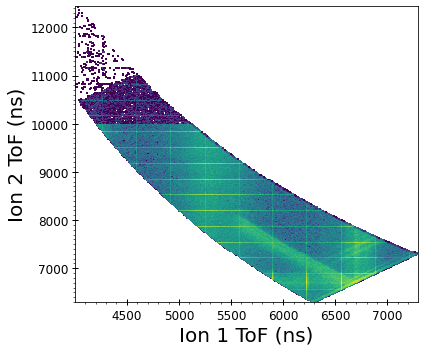

In [301]:
#%matplotlib.
fig, ax = plt.subplots(1,1,figsize=(6,5))

plt.hist2d(r1tof, r2tof, bins = (300,300), norm=LogNorm());#, cmap='hsv');
ax.set_xlabel('Ion 1 ToF (ns)',fontsize=20,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.set_ylabel('Ion 2 ToF (ns)',fontsize=20,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.xaxis.set_minor_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(100))
ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust the font size of major tick labels
ax.tick_params(axis='both', which='minor', labelsize=10)  # Adjust the font size of minor tick labels
ax.tick_params(direction='inout', length=6, width=1, colors='black', grid_color='r', grid_alpha=0.5)

fig.tight_layout()
#fig.show()

In [302]:
# def f(x):
#     return  0.0001*x*x - 3.0027*x + 20286

# def g(x):
#     return  0.0002*x*x - 3.0714*x + 20415

# # Find points where y is between f(x) and g(x)
# valid_points = [(r1tof_i, r2tof_i) for r1tof_i, r2tof_i in zip(r1tof, r2tof) if g(r1tof_i) <= r2tof_i <= f(r1tof_i)]

# # Extract the valid x and y values
# valid_x, valid_y = zip(*valid_points) if valid_points else ([], [])

# plt.hist2d(valid_x, valid_y, bins=(300,300));

In [303]:
if symmetrize_ion & (number_of_fragment == 2):
    print(symmetrize_ion)
    r_swap_mask_1 = np.random.randint(2, size=len(r1tof))
    r_swap_mask_2 = 1 - r_swap_mask_1 #create array that's the opposite of the top one

    # Assuming e_swap_mask_1, e1tof, and e2tof are your existing arrays
    r1tof_new = np.where(r_swap_mask_1 == 1, r2tof, r1tof)
    r2tof_new = np.where(r_swap_mask_1 == 1, r1tof, r2tof)
    r1x_new = np.where(r_swap_mask_1 == 1, r2x, r1x)
    r2x_new = np.where(r_swap_mask_1 == 1, r1x, r2x)
    r1y_new = np.where(r_swap_mask_1 == 1, r2y, r1y)
    r2y_new = np.where(r_swap_mask_1 == 1, r1y, r2y)

    r1tof_old = r1tof
    r2tof_old = r2tof
    r1x_old = r1x
    r2x_old = r2x
    r1y_old = r1y
    r2y_old = r2y

    r1tof = r1tof_new
    r2tof = r2tof_new
    r1x = r1x_new
    r2x = r2x_new
    r1y = r1y_new
    r2y = r2y_new

# # Now, e1tof_new and e2tof_new contain the swapped values based on the mask e_swap_mask_1


In [304]:
#############
### HIT 1 ###
#############
e_TOF0 = e1tof
e_x0 = e1x
e_y0 = e1y
i_TOF0 = r1tof
i_x0 = r1x
i_y0 = r1y

#############
### HIT 2 ###
#############
e_TOF1 = e2tof
e_x1 = e2x
e_y1 = e2y
i_TOF1 = r2tof
i_x1 = r2x
i_y1 = r2y

print(len(e_TOF0))
print(len(e_x0))

489518
489518


## Add in a filter to the data on the peaks we are interested in

In [305]:
## Add in a filter to the data on the peaks we are interested in


e1tof_filter = (e1tof > e1tof_left_edge) & (e1tof < e1tof_right_edge)
r1tof_filter = (r1tof > r1tof_left_edge) & (r1tof < r1tof_right_edge)
e2tof_filter = (e2tof > e2tof_left_edge) & (e2tof < e2tof_right_edge)
r2tof_filter = (r2tof > r2tof_left_edge) & (r2tof < r2tof_right_edge)

banana_sum_filter = ((r1tof+r2tof) > (13000)) & ((r1tof+r2tof) < (13700))
banana_diff_filter = ((r2tof-r1tof) > (0)) & ((r2tof-r1tof) < (3000))


r1loc_filter = (r1x > r1x_left_edge) & (r1x < r1x_right_edge) & (r1y > r1y_left_edge) & (r1y < r1y_right_edge) 
r2loc_filter = (r2x > r2x_left_edge) & (r2x < r2x_right_edge) & (r2y > r2y_left_edge) & (r2y < r2y_right_edge) 


if symmetrize_ion:
    r1r2_filter = True
    banana_sum_filter = True
    banana_diff_filter = True

else:
    r1r2_filter = r2tof>r1tof
    
if number_of_fragment == 1:
    keep_filter = e1tof_filter & r1tof_filter & r1loc_filter
else:
    keep_filter = e1tof_filter & r1tof_filter & e2tof_filter & r2tof_filter & r1r2_filter & r1loc_filter & r2loc_filter & banana_sum_filter & banana_diff_filter


final_filter = keep_filter #& ~delete_filter
#final_filter = e1tof_filter & r1tof_filter

e1tof_filtered = e1tof[final_filter]
e1x_filtered = e1x[final_filter]
e1y_filtered = e1y[final_filter]
e2tof_filtered = e2tof[final_filter]
e2x_filtered = e2x[final_filter]
e2y_filtered = e2y[final_filter]
r1tof_filtered = r1tof[final_filter]
r1x_filtered = r1x[final_filter]
r1y_filtered = r1y[final_filter]
r2tof_filtered = r2tof[final_filter]
r2x_filtered = r2x[final_filter]
r2y_filtered = r2y[final_filter]


print(len(r2y_filtered))
print(final_filter)

106789
[ True False False ... False False False]


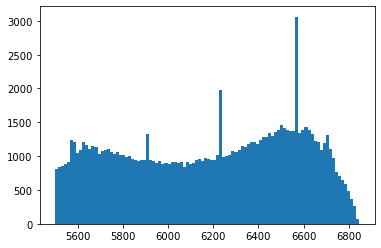

In [306]:
plt.hist(r1tof_filtered, bins=100);

[False False False ... False False False]


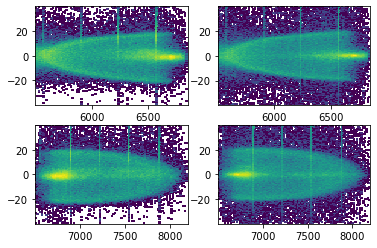

In [307]:
plt.subplot(2,2,1)
plt.hist2d(r1tof_filtered, r1x_filtered, bins=(100,100), norm=LogNorm());

plt.subplot(2,2,2)
plt.hist2d(r1tof_filtered, r1y_filtered, bins=(100,100), norm=LogNorm());

plt.subplot(2,2,3)
plt.hist2d(r2tof_filtered, r2x_filtered, bins=(100,100), norm=LogNorm());

plt.subplot(2,2,4)
plt.hist2d(r2tof_filtered, r2y_filtered, bins=(100,100), norm=LogNorm());

test = r1tof_filtered == r2tof_filtered
print(test)

In [308]:
#############
### HIT 1 ###
#############
e_TOF_0 = e1tof_filtered
e_x_0 = e1x_filtered
e_y_0 = e1y_filtered
i_TOF_0 = r1tof_filtered
i_x_0 = r1x_filtered
i_y_0 = r1y_filtered

###################################################################################
### applying rotation matrix by pi/2 to ion (x,y) hits to get detector oriented ###
###################################################################################
rot_ang = 0*np.pi/180
i_x0 = i_x_0*np.cos(rot_ang) - i_y_0*np.sin(rot_ang)
i_y0 = i_x_0*np.sin(rot_ang) + i_y_0*np.cos(rot_ang)

########################################################################################
### applying rotation matrix by pi/3 to electron (x,y) hits to get detector oriented ###
########################################################################################
#elec_det_theta = np.pi/3
elec_det_theta = 0
e_x0 = e_x_0*np.cos(elec_det_theta) - e_y_0*np.sin(elec_det_theta)
e_y0 = e_x_0*np.sin(elec_det_theta) + e_y_0*np.cos(elec_det_theta)

print(len(e_TOF_0))
print(len(e_x_0))

106789
106789


In [309]:
#############
### HIT 2 ###
#############
e_TOF_1 = e2tof_filtered
e_x_1 = e2x_filtered
e_y_1 = e2y_filtered
i_TOF_1 = r2tof_filtered
i_x_1 = r2x_filtered
i_y_1 = r2y_filtered

###################################################################################
### applying rotation matrix by pi/2 to ion (x,y) hits to get detector oriented ###
###################################################################################
i_x1 = i_x_1*np.cos(rot_ang) - i_y_1*np.sin(rot_ang)
i_y1 = i_x_1*np.sin(rot_ang) + i_y_1*np.cos(rot_ang)

########################################################################################
### applying rotation matrix by pi/3 to electron (x,y) hits to get detector oriented ###
########################################################################################
# elec_det_theta = np.pi/3
e_x1 = e_x_1*np.cos(elec_det_theta) - e_y_1*np.sin(elec_det_theta)
e_y1 = e_x_1*np.sin(elec_det_theta) + e_y_1*np.cos(elec_det_theta)

In [310]:
##########################################################
### apply TOF shift to electrons and ions if necessary ###
##########################################################
TOF_shift = -0

e_TOF0 = e_TOF_0 + TOF_shift
i_TOF0 = i_TOF_0 + TOF_shift

e_TOF1 = e_TOF_1 + TOF_shift
i_TOF1 = i_TOF_1 + TOF_shift

print(len(e_TOF_0))
print(len(e_x0))

106789
106789


1346.4327517014217


<ipython-input-311-e41deba8a520>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


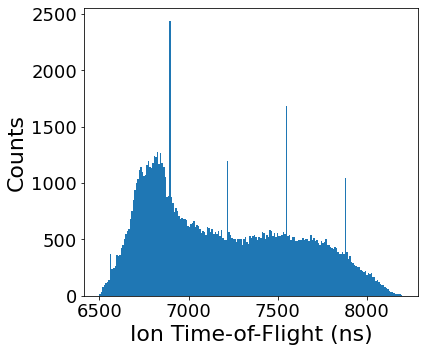

In [311]:
##################################
### make histogram of ion TOFs ###
##################################
fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.hist(i_TOF1,bins=200,histtype='stepfilled')
ax.set_xlabel('Ion Time-of-Flight (ns)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.set_ylabel('Counts',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.tick_params(labelsize=18)
fig.tight_layout()
fig.show()

print(np.amax(i_TOF0)-np.amin(i_TOF0)) #difference in max and min TOF

1697.0978876904865


<ipython-input-312-c12e4bf25149>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


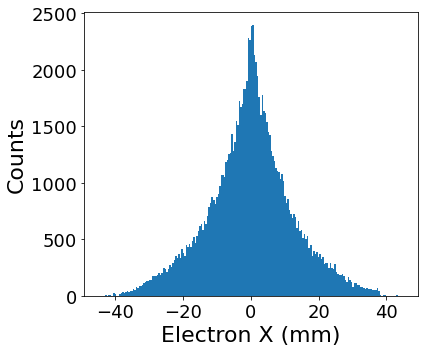

In [312]:
##################################
### make histogram of ion TOFs ###
##################################
fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.hist(e_x0,bins=200,histtype='stepfilled')
ax.set_xlabel('Electron X (mm)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.set_ylabel('Counts',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.tick_params(labelsize=18)
fig.tight_layout()
fig.show()

print(np.amax(i_TOF1)-np.amin(i_TOF1)) #difference in max and min TOF

### PIPICO

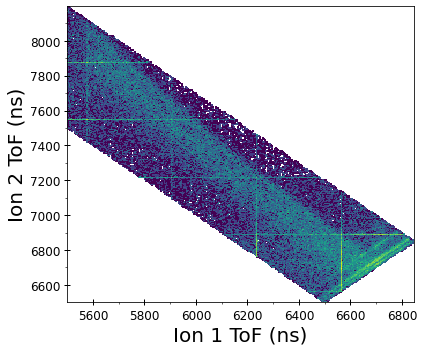

In [313]:
#%matplotlib.
fig, ax = plt.subplots(1,1,figsize=(6,5))

plt.hist2d(i_TOF0, i_TOF1, bins = (300,300), norm=LogNorm());#, cmap='hsv');
ax.set_xlabel('Ion 1 ToF (ns)',fontsize=20,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.set_ylabel('Ion 2 ToF (ns)',fontsize=20,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.xaxis.set_minor_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(100))
ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust the font size of major tick labels
ax.tick_params(axis='both', which='minor', labelsize=10)  # Adjust the font size of minor tick labels
ax.tick_params(direction='inout', length=6, width=1, colors='black', grid_color='r', grid_alpha=0.5)

fig.tight_layout()
#fig.show()

In [314]:
# from bokeh.plotting import figure, show, output_notebook
# from bokeh.models import ColumnDataSource, HoverTool
# from bokeh.transform import linear_cmap
# from bokeh.palettes import Turbo256

# # Ensure output is displayed in the Jupyter Notebook
# #output_notebook()


# # Create a 2D histogram using numpy
# hist, xedges, yedges = np.histogram2d(i_TOF0, i_TOF1, bins=200)

# # Flatten arrays to use with ColumnDataSource
# x_left = np.repeat(xedges[:-1], len(yedges)-1)
# x_right = np.repeat(xedges[1:], len(yedges)-1)
# y_bottom = np.tile(yedges[:-1], len(xedges)-1)
# y_top = np.tile(yedges[1:], len(xedges)-1)
# counts = hist.flatten()

# # Create a data source for Bokeh
# source = ColumnDataSource(data={
#     'x_left': x_left,
#     'x_right': x_right,
#     'y_bottom': y_bottom,
#     'y_top': y_top,
#     'counts': counts,
# })

# # Create a figure
# p = figure(title="2D Histogram with Hover Tool",
#            tools="hover",
#            tooltips=[("x", "@x_left"), ("y", "@y_bottom"), ("count", "@counts")])

# # Define a color mapper
# color_mapper = linear_cmap(field_name='counts', palette=Turbo256, low=counts.min(), high=counts.max())

# # Add a quad glyph for the histogram
# p.quad(top='y_top', bottom='y_bottom', left='x_left', right='x_right', 
#        source=source, fill_color=color_mapper, line_color='white', fill_alpha=0.7)

# # Show the plot
# show(p)

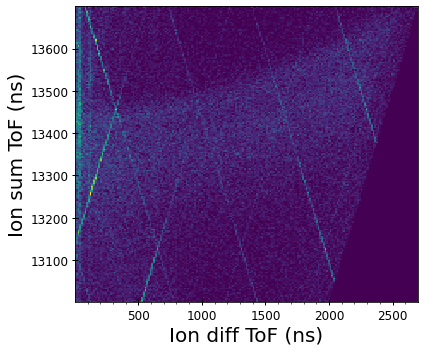

In [315]:
fig, ax = plt.subplots(1,1,figsize=(6,5))

plt.hist2d(i_TOF1-i_TOF0, i_TOF1+i_TOF0, bins = (200,200));#, cmap='hsv');
ax.set_xlabel('Ion diff ToF (ns)',fontsize=20,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.set_ylabel('Ion sum ToF (ns)',fontsize=20,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.xaxis.set_minor_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(100))
ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust the font size of major tick labels
ax.tick_params(axis='both', which='minor', labelsize=10)  # Adjust the font size of minor tick labels
ax.tick_params(direction='inout', length=6, width=1, colors='black', grid_color='r', grid_alpha=0.5)

fig.tight_layout()
#fig.show()

#################################
## top y = 0.0002x2 - 3.6165x + 22159
## bottom y = 0.0002x2 - 3.6165x + 22059
################################

#x-y fit

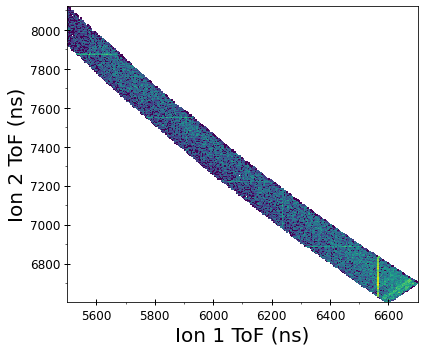

In [316]:
def top_tof(x):
    return  0.0002*x*x - 3.6265*x + 22120

def bottom_tof(x):
    return  0.0002*x*x - 3.6265*x + 22020

calc_tof1_top = top_tof(i_TOF0);
calc_tof1_bottom = bottom_tof(i_TOF0);

#plt.hist2d(i_TOF0, calcualted_i_TOF1, bins = (300,300));

###############
# for 46-46
##############
#para_filter = (i_TOF1 > calc_tof1_bottom) & (i_TOF1 < calc_tof1_top)

#############
#for 45-46
#############
para_filter = (i_TOF1 < calc_tof1_bottom) & (i_TOF1 > calc_tof1_bottom-200)


#print(len(i_TOF1[para_filter]))
#print(calc_tof1_bottom)
#print(i_TOF1)
#print(calc_tof1_top)

fig, ax = plt.subplots(1,1,figsize=(6,5))

plt.hist2d(i_TOF0[para_filter], i_TOF1[para_filter], bins = (300,300), norm=LogNorm());#, cmap='hsv');
ax.set_xlabel('Ion 1 ToF (ns)',fontsize=20,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.set_ylabel('Ion 2 ToF (ns)',fontsize=20,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.xaxis.set_minor_locator(ticker.MultipleLocator(100))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(100))
ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust the font size of major tick labels
ax.tick_params(axis='both', which='minor', labelsize=10)  # Adjust the font size of minor tick labels
ax.tick_params(direction='inout', length=6, width=1, colors='black', grid_color='r', grid_alpha=0.5)

fig.tight_layout()
#fig.show()

In [317]:
e_TOF0 = e_TOF0[para_filter]
e_x0 = e_x0[para_filter]
e_y0 = e_y0[para_filter]
i_TOF0 = i_TOF0[para_filter]
i_x0 = i_x0[para_filter]
i_y0 = i_y0[para_filter]
e_TOF1 = e_TOF1[para_filter]
e_x1 = e_x1[para_filter]
e_y1 = e_y1[para_filter]
i_TOF1 = i_TOF1[para_filter]
i_x1 = i_x1[para_filter]
i_y1 = i_y1[para_filter]


r_swap_mask_1 = np.random.randint(2, size=len(i_TOF0))
r_swap_mask_2 = 1 - r_swap_mask_1 #create array that's the opposite of the top one

# Assuming e_swap_mask_1, e1tof, and e2tof are your existing arrays
i_TOF0_new = np.where(r_swap_mask_1 == 1, i_TOF1, i_TOF0)
i_TOF1_new = np.where(r_swap_mask_1 == 1, i_TOF0, i_TOF1)
i_x0_new = np.where(r_swap_mask_1 == 1, i_x1, i_x0)
i_x1_new = np.where(r_swap_mask_1 == 1, i_x0, i_x1)
i_y0_new = np.where(r_swap_mask_1 == 1, i_y1, i_y0)
i_y1_new = np.where(r_swap_mask_1 == 1, i_y0, i_y1)

i_TOF0_old = i_TOF0
i_TOF1_old = i_TOF1
i_x0_old = i_x0
i_x1_old = i_x1
i_y0_old = i_y0
i_y1_old = i_y1

i_TOF0 = i_TOF0_new
i_TOF1 = i_TOF1_new
i_x0 = i_x0_new
i_x1 = i_x1_new
i_y0 = i_y0_new
i_y1 = i_y1_new


## Fit the TOF Data

In [318]:
#############################################
### fit ion TOFs with normal distribution ###
#############################################
(mu_iTOF0, sigma_iTOF0) = norm.fit(i_TOF0)
i_TOF_fit0 = mu_iTOF0
print("Center of First Ion")
print(i_TOF_fit0)

(mu_iTOF1, sigma_iTOF1) = norm.fit(i_TOF1)
i_TOF_fit1 = mu_iTOF1
print("Center of Second Ion")
print(i_TOF_fit1)

print("Center of Total Ion")
print((i_TOF_fit0+i_TOF_fit1)/2)

Center of First Ion
6678.5098748056025
Center of Second Ion
6685.288731237879
Center of Total Ion
6681.899303021741


-0.12991006348500364
0.7686184614083588


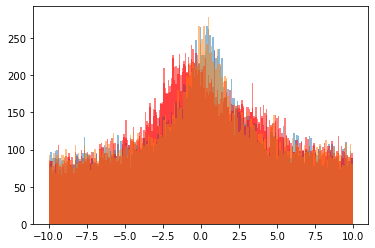

In [319]:
####################################
### histogram of ion x positions ###
####################################
ix_hist0 = plt.hist(i_x0,bins=np.linspace(-10,10,200),color='r', alpha=0.5)
ix_pairs0 = list(zip(*ix_hist0[0:2]))
i_x_offset0 = max(ix_pairs0)[1]

####################################
### histogram of ion y positions ###
####################################
iy_hist0 = plt.hist(i_y0,bins=np.linspace(-10,10,200),alpha=0.5)
iy_pairs0 = list(zip(*iy_hist0[0:2]))
i_y_offset0 = max(iy_pairs0)[1]

#####################################
### fitting electron1 x positions ###
#####################################
(mu_ex0, sigma_ex0) = norm.fit(e_x0)
e_x_offset0 = mu_ex0

#####################################
### fitting electron1 y positions ###
#####################################
(mu_ey0, sigma_ey0) = norm.fit(e_y0)
e_y_offset0 = mu_ey0

####################################
### histogram of ion x positions ###
####################################
ix_hist1 = plt.hist(i_x1,bins=np.linspace(-10,10,200),color='r',alpha=0.5)
ix_pairs1 = list(zip(*ix_hist1[0:2]))
i_x_offset1 = max(ix_pairs1)[1]

####################################
### histogram of ion y positions ###
####################################
iy_hist1 = plt.hist(i_y1,bins=np.linspace(-10,10,200),alpha=0.5)
iy_pairs1 = list(zip(*iy_hist1[0:2]))
i_y_offset1 = max(iy_pairs1)[1]

#####################################
### fitting electron2 x positions ###
#####################################
(mu_ex1, sigma_ex1) = norm.fit(e_x1)
e_x_offset1 = mu_ex1

#####################################
### fitting electron2 y positions ###
#####################################
(mu_ey1, sigma_ey1) = norm.fit(e_y1)
e_y_offset1 = mu_ey1

print(mu_ex0)
print(mu_ey0)

In [320]:
############################################################
### offset ion (x,y) hit positions to center on detector ###
############################################################
i_x0 = i_x0 - i_x_offset0
i_y0 = i_y0 - i_y_offset0

i_x1 = i_x1 - i_x_offset1
i_y1 = i_y1 - i_y_offset1

###################################################################
#### offset electron (x,y) hit positions to center on detector ####
## not always necessary and can be checked to see if beneficial ###
###################################################################
#e_x = e_x - mu_ex
#e_y = e_y - mu_ey

## Ion Fish

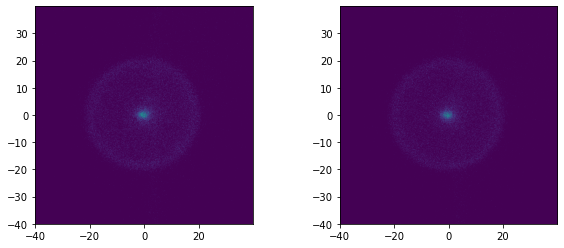

In [321]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

###########################
##### ion (x,y) hit 1 #####
###########################
pos_ix_edges = np.arange(-40,40,0.1)
pos_iy_edges = np.arange(-40,40,0.1)
H_i_pos0, ix_edges, iy_edges = np.histogram2d(i_x0,i_y0,bins=(pos_ix_edges,pos_iy_edges))
H_i_pos0 = H_i_pos0.T

ax1.imshow(H_i_pos0, origin='lower', extent=[pos_ix_edges[0], pos_ix_edges[-1], pos_iy_edges[0], pos_iy_edges[-1]],cmap='viridis')

###########################
##### ion (x,y) hit 2 #####
###########################
pos_ix_edges = np.arange(-40,40,0.1)
pos_iy_edges = np.arange(-40,40,0.1)
H_i_pos1, ix_edges, iy_edges = np.histogram2d(i_x1,i_y1,bins=(pos_ix_edges,pos_iy_edges))
H_i_pos1 = H_i_pos1.T

ax2.imshow(H_i_pos1, origin='lower', extent=[pos_ix_edges[0], pos_ix_edges[-1], pos_iy_edges[0], pos_iy_edges[-1]],cmap='viridis')

## Electron Fish

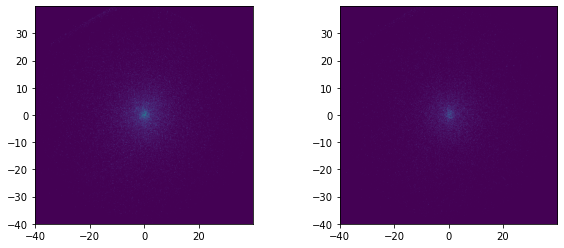

In [322]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

###########################
##### ion (x,y) hit 1 #####
###########################
pos_ix_edges = np.arange(-40,40,0.1)
pos_iy_edges = np.arange(-40,40,0.1)
H_i_pos0, ix_edges, iy_edges = np.histogram2d(e_x_0,e_y_0,bins=(pos_ix_edges,pos_iy_edges))
H_i_pos0 = H_i_pos0.T

ax1.imshow(H_i_pos0, origin='lower', extent=[pos_ix_edges[0], pos_ix_edges[-1], pos_iy_edges[0], pos_iy_edges[-1]],cmap='viridis')

###########################
##### ion (x,y) hit 2 #####
###########################
pos_ix_edges = np.arange(-40,40,0.1)
pos_iy_edges = np.arange(-40,40,0.1)
H_i_pos1, ix_edges, iy_edges = np.histogram2d(e_x1,e_y1,bins=(pos_ix_edges,pos_iy_edges))
H_i_pos1 = H_i_pos1.T

ax2.imshow(H_i_pos1, origin='lower', extent=[pos_ix_edges[0], pos_ix_edges[-1], pos_iy_edges[0], pos_iy_edges[-1]],cmap='viridis')

2612.9753082369425


<ipython-input-323-da88e52db40c>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


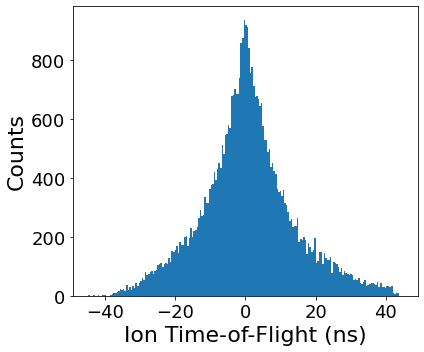

In [323]:
##################################
### make histogram of ion TOFs ###
##################################
fig, ax = plt.subplots(1,1,figsize=(6,5))

ax.hist(e_y0,bins=200,histtype='stepfilled')
ax.set_xlabel('Ion Time-of-Flight (ns)',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.set_ylabel('Counts',fontsize=22,fontdict = {'family' : 'sans-serif', 'weight' : 'normal'})
ax.tick_params(labelsize=18)
fig.tight_layout()
fig.show()

print(np.amax(i_TOF0)-np.amin(i_TOF0)) #difference in max and min TOF

In [324]:
len(e_TOF0)
#len(e_x0)

43035

<ipython-input-325-4ee0e662af2b>:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


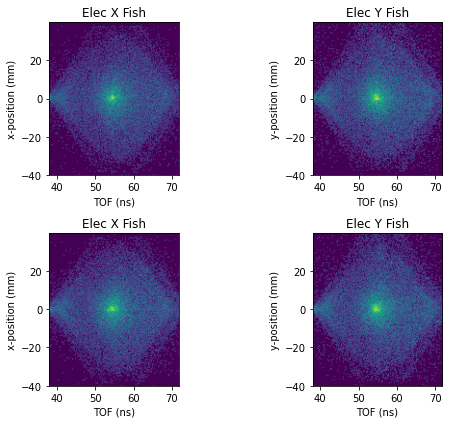

In [325]:
#############################
########### hit 1 ###########
###### 'electron fish' ######
#### (TOF,x) and (TOF,y) ####
#############################
fig, axs = plt.subplots(2,2,figsize=(8,6))

eTOF_edges = np.arange(e1tof_left_edge, e1tof_right_edge,0.25)
ex_edges = np.arange(-40,40,0.25)
ey_edges = np.arange(-40,40,0.25)

H_ex_fish, eTOF_edges, exfish_edges = np.histogram2d(e_TOF0,e_x0,bins=(eTOF_edges,ex_edges))
H_ex_fish = H_ex_fish.T

H_ey_fish, eTOF_edges, eyfish_edges = np.histogram2d(e_TOF0,e_y0,bins=(eTOF_edges,ey_edges))
H_ey_fish = H_ey_fish.T

axs[0,0].imshow(H_ex_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], exfish_edges[0], exfish_edges[-1]],aspect=1/2,cmap='viridis',norm=PowerNorm(gamma=1/2))
axs[0,0].set_title('Elec X Fish')
axs[0,0].set_xlabel('TOF (ns)')
axs[0,0].set_ylabel('x-position (mm)')
axs[0,1].imshow(H_ey_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], eyfish_edges[0], eyfish_edges[-1]],aspect=1/2,cmap='viridis',norm=PowerNorm(gamma=1/2))
axs[0,1].set_title('Elec Y Fish')
axs[0,1].set_xlabel('TOF (ns)')
axs[0,1].set_ylabel('y-position (mm)')


H_ex_fish, eTOF_edges, exfish_edges = np.histogram2d(e_TOF1,e_x1,bins=(eTOF_edges,ex_edges))
H_ex_fish = H_ex_fish.T

H_ey_fish, eTOF_edges, eyfish_edges = np.histogram2d(e_TOF1,e_y1,bins=(eTOF_edges,ey_edges))
H_ey_fish = H_ey_fish.T

axs[1,0].imshow(H_ex_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], exfish_edges[0], exfish_edges[-1]],aspect=25/50,cmap='viridis',norm=PowerNorm(gamma=1/2))
axs[1,0].set_title('Elec X Fish')
axs[1,0].set_xlabel('TOF (ns)')
axs[1,0].set_ylabel('x-position (mm)')
axs[1,1].imshow(H_ey_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], eyfish_edges[0], eyfish_edges[-1]],aspect=25/50,cmap='viridis',norm=PowerNorm(gamma=1/2))
axs[1,1].set_title('Elec Y Fish')
axs[1,1].set_xlabel('TOF (ns)')
axs[1,1].set_ylabel('y-position (mm)')

fig.tight_layout()
fig.show()

<ipython-input-326-cd97c6323f96>:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


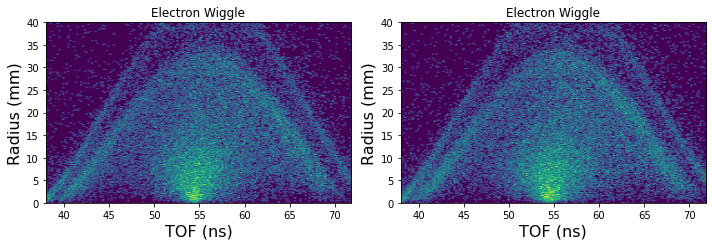

In [326]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

###############################
############ hit 1 ############
###### 'electron wiggle' ######
########### (TOF,r) ###########
###############################

### compute radius for (x,y) hit position ###
e_rad0 = np.sqrt(e_x0**2 + e_y0**2)

eTOF_edges = np.arange(e1tof_left_edge,e1tof_right_edge,0.2)
ewiggle_edges = np.arange(0,40.2,0.2)

H_e0_wiggle0, eTOF_edges, ewiggle_edges = np.histogram2d(e_TOF0,e_rad0,bins=(eTOF_edges,ewiggle_edges))
H_e0_wiggle0 = H_e0_wiggle0.T

ax1.imshow(H_e0_wiggle0, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], ewiggle_edges[0], ewiggle_edges[-1]],aspect=20/40,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax1.set_title('Electron Wiggle')
ax1.set_xlabel('TOF (ns)', fontsize=16)
ax1.set_ylabel('Radius (mm)', fontsize=16)

###############################
############ hit 2 ############
###### 'electron wiggle' ######
########### (TOF,r) ###########
###############################

### compute radius for (x,y) hit position ###
e_rad1 = np.sqrt(e_x1**2 + e_y1**2)

eTOF_edges = np.arange(e1tof_left_edge,e1tof_right_edge,0.2)
ewiggle_edges = np.arange(0,40.2,0.2)

H_e0_wiggle1, eTOF_edges, ewiggle_edges = np.histogram2d(e_TOF1,e_rad1,bins=(eTOF_edges,ewiggle_edges))
H_e0_wiggle1 = H_e0_wiggle1.T

ax2.imshow(H_e0_wiggle1, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], ewiggle_edges[0], ewiggle_edges[-1]],aspect=20/40,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax2.set_title('Electron Wiggle')
ax2.set_xlabel('TOF (ns)', fontsize=16)
ax2.set_ylabel('Radius (mm)', fontsize=16)

fig.tight_layout()
fig.show()

In [327]:
##############################################################
##### correct electron hit 1 E x B drift in spectrometer #####
########## apply same correction to electron hit 2 ###########
##############################################################
wiggles_tof_ex = [38, 72, 1.0, 1.0] #node positions in TOF is what changes
wiggles_tof_ey = [38, 72, 0.0, -1.0]

ex_corr = np.polyfit(wiggles_tof_ex[0:2], wiggles_tof_ex[2:], 1)
px = np.poly1d(ex_corr)
ey_corr = np.polyfit(wiggles_tof_ey[0:2], wiggles_tof_ey[2:], 1)
py = np.poly1d(ey_corr)

e_x0 = e_x0 - px(e_TOF0)
e_y0 = e_y0 - py(e_TOF0)

e_x1 = e_x1 - px(e_TOF1)
e_y1 = e_y1 - py(e_TOF1)

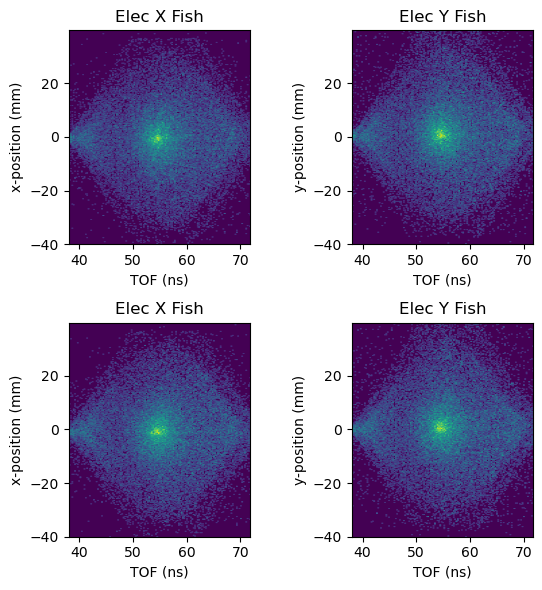

In [328]:
###############################
### corrected electron fish ###
###############################
fig, axs = plt.subplots(2,2,figsize=(6,6), dpi=100)

#### Hit 1 ####
eTOF_edges = np.arange(e1tof_left_edge,e1tof_right_edge,0.25)
#eTOF_edges = np.arange(42,68,0.25)

ex_edges = np.arange(-40,40,0.25)
ey_edges = np.arange(-40,40,0.25)

H_ex_fish, eTOF_edges, exfish_edges = np.histogram2d(e_TOF0,e_x0,bins=(eTOF_edges,ex_edges))
H_ex_fish = H_ex_fish.T

H_ey_fish, eTOF_edges, eyfish_edges = np.histogram2d(e_TOF0,e_y0,bins=(eTOF_edges,ey_edges))
H_ey_fish = H_ey_fish.T

axs[0,0].imshow(H_ex_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], exfish_edges[0], exfish_edges[-1]],aspect=1/2,cmap='viridis',norm=PowerNorm(gamma=1/2))
axs[0,0].set_title('Elec X Fish')
axs[0,0].set_xlabel('TOF (ns)')
axs[0,0].set_ylabel('x-position (mm)')
axs[0,1].imshow(H_ey_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], eyfish_edges[0], eyfish_edges[-1]],aspect=1/2,cmap='viridis',norm=PowerNorm(gamma=1/2))
axs[0,1].set_title('Elec Y Fish')
axs[0,1].set_xlabel('TOF (ns)')
axs[0,1].set_ylabel('y-position (mm)')

### Hit 2 ####
H_ex_fish, eTOF_edges, exfish_edges = np.histogram2d(e_TOF1,e_x1,bins=(eTOF_edges,ex_edges))
H_ex_fish = H_ex_fish.T

H_ey_fish, eTOF_edges, eyfish_edges = np.histogram2d(e_TOF1,e_y1,bins=(eTOF_edges,ey_edges))
H_ey_fish = H_ey_fish.T

axs[1,0].imshow(H_ex_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], exfish_edges[0], exfish_edges[-1]],aspect=1/2,cmap='viridis',norm=PowerNorm(gamma=1/2))
axs[1,0].set_title('Elec X Fish')
axs[1,0].set_xlabel('TOF (ns)')
axs[1,0].set_ylabel('x-position (mm)')
axs[1,1].imshow(H_ey_fish, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], eyfish_edges[0], eyfish_edges[-1]],aspect=1/2,cmap='viridis',norm=PowerNorm(gamma=1/2))
axs[1,1].set_title('Elec Y Fish')
axs[1,1].set_xlabel('TOF (ns)')
axs[1,1].set_ylabel('y-position (mm)')

fig.tight_layout()
#fig.show()

<ipython-input-329-4fbdb51ce135>:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


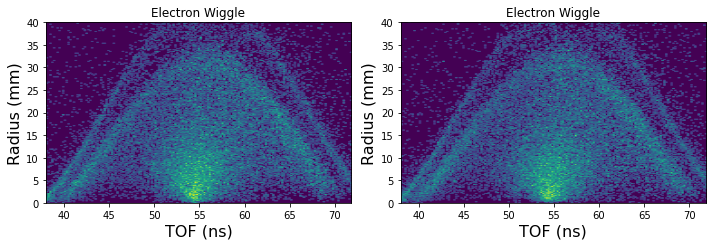

In [329]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

###############################
############ hit 1 ############
###### 'Corrected electron wiggle' ######
########### (TOF,r) ###########
###############################

### compute radius for (x,y) hit position ###
e_rad0 = np.sqrt(e_x0**2 + e_y0**2)

eTOF_edges = np.arange(e1tof_left_edge,e1tof_right_edge,0.2)
ewiggle_edges = np.arange(0,40.2,0.2)

H_e0_wiggle0, eTOF_edges, ewiggle_edges = np.histogram2d(e_TOF0,e_rad0,bins=(eTOF_edges,ewiggle_edges))
H_e0_wiggle0 = H_e0_wiggle0.T

ax1.imshow(H_e0_wiggle0, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], ewiggle_edges[0], ewiggle_edges[-1]],aspect=20/40,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax1.set_title('Electron Wiggle')
ax1.set_xlabel('TOF (ns)', fontsize=16)
ax1.set_ylabel('Radius (mm)', fontsize=16)

###############################
############ hit 2 ############
###### 'Corrected electron wiggle' ######
########### (TOF,r) ###########
###############################

### compute radius for (x,y) hit position ###
e_rad1 = np.sqrt(e_x1**2 + e_y1**2)

eTOF_edges = np.arange(e1tof_left_edge,e1tof_right_edge,0.2)
ewiggle_edges = np.arange(0,40.2,0.2)

H_e0_wiggle1, eTOF_edges, ewiggle_edges = np.histogram2d(e_TOF1,e_rad1,bins=(eTOF_edges,ewiggle_edges))
H_e0_wiggle1 = H_e0_wiggle1.T

ax2.imshow(H_e0_wiggle1, origin='lower', extent=[eTOF_edges[0], eTOF_edges[-1], ewiggle_edges[0], ewiggle_edges[-1]],aspect=20/40,cmap='viridis',norm=PowerNorm(gamma=1/2))
ax2.set_title('Electron Wiggle')
ax2.set_xlabel('TOF (ns)', fontsize=16)
ax2.set_ylabel('Radius (mm)', fontsize=16)

fig.tight_layout()
fig.show()

## Ion Fish

<ipython-input-330-259b4c2b8a0b>:12: RuntimeWarning: divide by zero encountered in log
  H_ix_fish = np.log(H_ix_fish.T)
<ipython-input-330-259b4c2b8a0b>:15: RuntimeWarning: divide by zero encountered in log
  H_iy_fish = np.log(H_iy_fish.T)


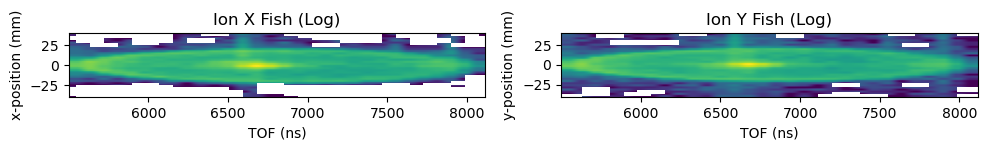

In [330]:
##########################
########## hit 1 #########
### corrected ion fish ###
##########################
fig1, (ax11, ax22) = plt.subplots(1, 2, figsize=(10, 10), dpi=100)  # Larger figure size

iTOF_edges = np.arange(r1tof_left_edge, r1tof_right_edge, 2.0)
ix_edges = np.arange(-30, 30, 0.1)
iy_edges = np.arange(-30, 30, 0.1)

H_ix_fish, iTOF_edges, ixfish_edges = np.histogram2d(i_TOF0, i_x0, bins=(30, 30))
H_ix_fish = np.log(H_ix_fish.T)

H_iy_fish, iTOF_edges, iyfish_edges = np.histogram2d(i_TOF0, i_y0, bins=(30, 30))
H_iy_fish = np.log(H_iy_fish.T)

ax11.imshow(H_ix_fish, origin='lower', extent=[iTOF_edges[0], iTOF_edges[-1], ixfish_edges[0], ixfish_edges[-1]], aspect=5/1, cmap='viridis')
ax11.set_title('Ion X Fish (Log)')
ax11.set_xlabel('TOF (ns)')
ax11.set_ylabel('x-position (mm)')

ax22.imshow(H_iy_fish, origin='lower', extent=[iTOF_edges[0], iTOF_edges[-1], iyfish_edges[0], iyfish_edges[-1]], aspect=5/1, cmap='viridis')
ax22.set_title('Ion Y Fish (Log)')
ax22.set_xlabel('TOF (ns)')
ax22.set_ylabel('y-position (mm)')

fig1.tight_layout()
plt.show()

<ipython-input-331-d5863a08aceb>:12: RuntimeWarning: divide by zero encountered in log
  H_ix_fish = np.log(H_ix_fish.T)
<ipython-input-331-d5863a08aceb>:15: RuntimeWarning: divide by zero encountered in log
  H_iy_fish = np.log(H_iy_fish.T)
<ipython-input-331-d5863a08aceb>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


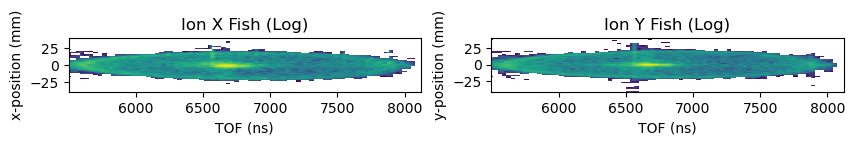

In [331]:
##########################
########## hit 2 #########
### corrected ion fish ###
##########################
fig1, (ax11, ax22) = plt.subplots(1,2,figsize=(10,10), dpi=100)

iTOF_edges = np.arange(r2tof_left_edge,r2tof_right_edge,2.0)
ix_edges = np.arange(-30,30,0.1)
iy_edges = np.arange(-30,30,0.1)

H_ix_fish, iTOF_edges, ixfish_edges = np.histogram2d(i_TOF1,i_x1,bins=(80,80))
H_ix_fish = np.log(H_ix_fish.T)

H_iy_fish, iTOF_edges, iyfish_edges = np.histogram2d(i_TOF1,i_y1,bins=(80,80))
H_iy_fish = np.log(H_iy_fish.T)

ax11.imshow(H_ix_fish, origin='lower', extent=[iTOF_edges[0], iTOF_edges[-1], ixfish_edges[0], ixfish_edges[-1]],aspect = 5/1,cmap='viridis')
ax11.set_title('Ion X Fish (Log)')
ax11.set_xlabel('TOF (ns)')
ax11.set_ylabel('x-position (mm)')
ax22.imshow(H_iy_fish, origin='lower', extent=[iTOF_edges[0], iTOF_edges[-1], iyfish_edges[0], iyfish_edges[-1]],aspect = 5/1,cmap='viridis')
ax22.set_title('Ion Y Fish (Log)')
ax22.set_xlabel('TOF (ns)')
ax22.set_ylabel('y-position (mm)')

#fig1.tight_layout()
fig1.show()

# Transforming from (x,y,TOF) to (px,py,pz)

### We now begin steps to convert from raw measured data to momentum distributions

## Functions

In [332]:
##############################################################
### function for computing particle velocity distributions ###
##############################################################

def NEW_v(acc_1, acc_2, acc_3, acc1_length, acc2_length, acc3_length, velo, tof):

    if acc_2 != 0.0 and  acc2_length != 0.0:
        a2_term = (-np.sqrt(2.0*acc_1*acc1_length + velo**2) + 
                   np.sqrt(2.0*acc_1*acc1_length + 2.0*acc_2*acc2_length + velo**2))/acc_2    
    elif acc2_length != 0.0 and acc_2 == 0.0:
        a2_term = acc2_length/np.sqrt(2*acc_1*acc1_length + velo**2)    
    else:
        a2_term = 0.0

    if acc_3 != 0.0 and  acc3_length != 0.0:
        a3_term = (-np.sqrt(2.0*acc_1*acc1_length + 2.0*acc_2*acc2_length + velo**2) + 
                   np.sqrt(2.0*acc_1*acc1_length + 2.0*acc_2*acc2_length + 2.0*acc_3*acc3_length + velo**2))/acc_3   
    elif acc3_length != 0.0 and acc_3 == 0.0:
        a3_term = acc3_length/np.sqrt(2*acc_1*acc1_length + 2*acc_2*acc2_length + velo**2)
    else:
        a3_term = 0.0

    t_function = -tof + (-velo + np.sqrt(2.0*acc_1*acc1_length + velo**2))/acc_1 + a2_term + a3_term 
    v1 = velo*(1.01)

    if acc_2 != 0.0 and  acc2_length != 0.0:
        a2_term = (-np.sqrt(2.0*acc_1*acc1_length + v1**2) + 
                   np.sqrt(2.0*acc_1*acc1_length + 2.0*acc_2*acc2_length + v1**2))/acc_2    
    elif acc2_length != 0.0 and acc_2 == 0.0:
        a2_term = acc2_length/np.sqrt(2*acc_1*acc1_length + v1**2)   
    else:
        a2_term = 0.0

    if acc_3 != 0.0 and  acc3_length != 0.0:
        a3_term = (-np.sqrt(2.0*acc_1*acc1_length + 2.0*acc_2*acc2_length + v1**2) + 
                   np.sqrt(2.0*acc_1*acc1_length + 2.0*acc_2*acc2_length + 2.0*acc_3*acc3_length + v1**2))/acc_3    
    elif acc3_length != 0. and acc_3 == 0.0:
        a3_term = acc3_length/np.sqrt(2*acc_1*acc1_length + 2*acc_2*acc2_length + v1**2) 
    else:
        a3_term = 0.0

    Dt_function_dv = ( (-tof + (-v1 + np.sqrt(2.0*acc_1*acc1_length + v1**2)) / acc_1 
                        + a2_term + a3_term) - t_function ) / (v1 - velo) 
    return velo - t_function / Dt_function_dv

In [333]:

def tof2mom_3accel(tof_ns, acc1mm, acc2mm, acc3mm, Efield1_Vpcm, Efield2_Vpcm, Efield3_Vpcm, charge_au, mass_amu):
    E_Field_au_over_si = 1.0 / 5.1421e11 #au * m / V
    length_au_over_m = 1.0 / 5.2917720859e-11 #au / m
    time_au_over_s = 1.0 / 2.418884326505e-17 #au / s
    AUmass_over_AMU = 1.660538782e-27 / 9.10938215e-31 #(au / kg) * (kg / amu)

    t = (tof_ns * 1e-9) * time_au_over_s
    mass = mass_amu * AUmass_over_AMU
    q = charge_au
    acc1_length = acc1mm * 0.001 * length_au_over_m
    acc2_length = acc2mm * 0.001 * length_au_over_m
    acc3_length = acc3mm * 0.001 * length_au_over_m
    Efield1_Vau = Efield1_Vpcm * 100.0 * E_Field_au_over_si
    Efield2_Vau = Efield2_Vpcm * 100.0 * E_Field_au_over_si
    Efield3_Vau = Efield3_Vpcm * 100.0 * E_Field_au_over_si

    acc1 = (Efield1_Vau * q) / mass
    acc2 = (Efield2_Vau * q) / mass
    acc3 = (Efield3_Vau * q) / mass

    acc1_temp = np.where(acc1 != 0, acc1, 0.001)
    acc2_temp = np.where(acc2 != 0, acc2, 0.001)
    acc3_temp = np.where(acc3 != 0, acc3, 0.001)

    v = np.sqrt(2.0) * np.sqrt(acc1_temp * acc1_length) - \
        (np.sqrt(2.0) * acc1_temp * np.sqrt(acc1_temp * acc1_length) / acc2_temp) + \
        (np.sqrt(2.0) * acc1_temp * np.sqrt(acc1_temp * acc1_length + acc2_temp * acc2_length) / acc2_temp) - \
        (np.sqrt(2.0) * acc1_temp * np.sqrt(acc1_temp * acc1_length + acc2_temp * acc2_length) / acc3_temp) + \
        (np.sqrt(2.0) * acc1_temp * np.sqrt(acc1_temp * acc1_length + acc2_temp * acc2_length + acc3_temp * acc3_length) / acc3_temp) - \
        acc1_temp * t

    for i in range(len(tof_ns)):
        new_v = 0.0
        shift_counter = 1
        for j in range(50):
            new_v = NEW_v(acc1, acc2, acc3, acc1_length, acc2_length, acc3_length, v[i], t[i])

            if np.isinf(new_v) == 1:
                new_v = v[i] * (1.0 + 2.0 ** shift_counter / 1000.0)
                shift_counter += 1
            else:
                shift_counter = 1

            if np.abs((new_v * mass - v[i] * mass) / (v[i] * mass)) < 1e-6:
                break

            v[i] = new_v

    p_z = v * mass
    return p_z


In [334]:
def calc_px(tof_ns, x_mm, y_mm, mass_amu, charge_au, BField_ns, BField_clockwise=True):
    MEKG = 9.10938356e-31  # kg
    COULOMB = 1.602176634e-19  # C
    MASSAU = 1.66053906660e-27  # kg
    time_au_over_s = 1.0 / 2.418884326505e-17 #au / s
    dist_au_over_m = 1.0 / 5.29177210903e-11 # au / m
    mass_au_over_amu = 1.660538782e-27 / 9.10938215e-31 #(au / kg) * (kg / amu)
 
    
    #convert all to a.u.
    tof_au = tof_ns * 1e-9 * time_au_over_s
    x_au = x_mm * 1e-3 * dist_au_over_m
    y_au = y_mm * 1e-3 * dist_au_over_m
    mass_au = mass_amu * mass_au_over_amu

    if mass_amu < 1.0:
        w, a, b = 0.0, 0.0, 0.0

        m = mass_amu * MASSAU * MEKG
        q = charge_au * COULOMB
        pau = m * 300e6 / 137.

        fieldB = 2. * m * 3.14152 / (q * BField_ns * 1e-9)

        if BField_clockwise:
            fieldB = -fieldB

        w = q / m * fieldB
        a = (1. - np.cos(w * tof_ns * 1e-9)) / w
        b = (np.sin(w * tof_ns * 1e-9)) / w

        px = m * (x_mm / 1000. * b + a * y_mm / 1000.) / (a * a + b * b)
        px = px / pau
    else:
        #vau = 2.1877e+6
        px = x_au / tof_au * mass_au

    return px


In [335]:
def calc_py(tof_ns, x_mm, y_mm, mass_amu, charge_au, BField_ns, BField_clockwise=True):
    MEKG = 9.10938356e-31  # kg
    COULOMB = 1.602176634e-19  # C
    MASSAU = 1.66053906660e-27  # kg
    time_au_over_s = 1.0 / 2.418884326505e-17 #au / s
    dist_au_over_m = 1.0 / 5.29177210903e-11 # au / m
    mass_au_over_amu = 1.660538782e-27 / 9.10938215e-31 #(au / kg) * (kg / amu)
 
    #convert all to a.u.
    tof_au = tof_ns * 1e-9 * time_au_over_s
    x_au = x_mm * 1e-3 * dist_au_over_m
    y_au = y_mm * 1e-3 * dist_au_over_m
    mass_au = mass_amu * mass_au_over_amu
    
    if mass_amu < 1.0:
        w, a, b = 0.0, 0.0, 0.0

        m = mass_amu * MASSAU * MEKG
        q = charge_au * COULOMB
        pau = m * 300e6 / 137.

        fieldB = 2. * m * 3.14152 / (q * BField_ns * 1e-9)

        if BField_clockwise:
            fieldB = -fieldB

        w = q / m * fieldB
        a = (1. - np.cos(w * tof_ns * 1e-9)) / w
        b = (np.sin(w * tof_ns * 1e-9)) / w

        py = m * (-x_mm / 1000. * a + b * y_mm / 1000.) / (a * a + b * b)

        py = py / pau
    else:
        py = y_au / tof_au * mass_au

    return py


In [336]:
def calc_pze(tof_ns, x_mm, y_mm, mass_amu, charge_au, para_a, para_b, para_c, acc1mm, acc2mm, acc3mm, Efield1_Vpcm, Efield2_Vpcm, Efield3_Vpcm, BField_ns, BField_clockwise=True):
    px, py, pz, E1 = 0, 0, 0, 0

    if mass_amu < 1.:
        m = mass_amu * 1.66053906660e-27  # Convert mass from atomic mass units to kg
        q = -charge_au * 1.602176634e-19  # Convert charge from atomic units to coulombs
        pau = m * 300e6 / 137.036  # Atomic unit of momentum

        fieldB = 2. * m * np.pi / (q * BField_ns * 1e-9)

        if BField_clockwise:
            fieldB = -fieldB

        w = q / m * fieldB
        a = (1. - np.cos(w * tof_ns * 1.e-9)) / w
        b = (np.sin(w * tof_ns * 1.e-9)) / w

        px = m * (x_mm / 1000. * b + a * y_mm / 1000.) / (a**2 + b**2)
        px /= pau
        py = m * (-x_mm / 1000. * a + b * y_mm / 1000.) / (a**2 + b**2)
        py /= pau

        q = -charge_au
        m = mass_amu
        E1 = Efield1_Vpcm
        pz = -tof2mom_3accel(tof_ns, acc1mm, acc2mm, acc3mm, E1, Efield2_Vpcm, Efield3_Vpcm, q, m)
        
#         for i in range(50):
#             if np.abs(para_a - para_b * np.power(para_c, (px**2 + py**2 + pz**2) * pau**2 / (2 * m[:,0] * q)) - E1) > 1e-4:
#                 E1 = para_a - para_b * np.power(para_c, (px**2 + py**2 + pz**2) * pau**2 / (2 * m * q))
#                 pz = -tof2mom_3accel(tof_ns, acc1mm, acc2mm, acc3mm, E1, Efield2_Vpcm, Efield3_Vpcm, q, m)

    return pz

In [337]:
def calc_Y0(tof1_ns, tof2_ns, y1_mm, y2_mm, mass1_amu, mass2_amu):
    Y0 = (mass1_amu * y1_mm * tof2_ns + mass2_amu * y2_mm * tof1_ns) / (mass1_amu * tof2_ns + mass2_amu * tof1_ns)
    return Y0

def calc_X0(tof1_ns, tof2_ns, x1_mm, x2_mm, mass1_amu, mass2_amu):
    X0 = (mass1_amu * x1_mm * tof2_ns + mass2_amu * x2_mm * tof1_ns) / (mass1_amu * tof2_ns + mass2_amu * tof1_ns)
    # Uncomment the following line if you want to include the effect of the jet velocity
    # X0 -= ((mass1_amu + mass2_amu) * tof2_ns * tof1_ns / (mass1_amu * tof2_ns + mass2_amu * tof1_ns)) * VJet * (1E+3 * 1E-9)
    return X0


In [338]:
import numpy as np

def calc_Z0(tof1_ns, tof2_ns, acc1mm, acc2mm, acc3mm, Efield1_Vpcm, Efield2_Vpcm, Efield3_Vpcm, charge1_au, charge2_au, mass1_amu, mass2_amu):
    Kg_over_AMU = 1.660538782e-27
    C_over_au = 1.602176487e-19

    acc11 = (Efield1_Vpcm * charge1_au) / (mass1_amu * (1e+2 * C_over_au / Kg_over_AMU))
    acc12 = (Efield2_Vpcm * charge1_au) / (mass1_amu * (1e+2 * C_over_au / Kg_over_AMU))
    acc13 = (Efield3_Vpcm * charge1_au) / (mass1_amu * (1e+2 * C_over_au / Kg_over_AMU))
    acc21 = (Efield1_Vpcm * charge2_au) / (mass2_amu * (1e+2 * C_over_au / Kg_over_AMU))
    acc22 = (Efield2_Vpcm * charge2_au) / (mass2_amu * (1e+2 * C_over_au / Kg_over_AMU))
    acc23 = (Efield3_Vpcm * charge2_au) / (mass2_amu * (1e+2 * C_over_au / Kg_over_AMU))

    acc11_temp = np.where(acc11 != 0., acc11, 0.001)
    acc12_temp = np.where(acc12 != 0., acc12, 0.001)
    acc13_temp = np.where(acc13 != 0., acc13, 0.001)
    acc21_temp = np.where(acc21 != 0., acc21, 0.001)
    acc22_temp = np.where(acc22 != 0., acc22, 0.001)
    acc23_temp = np.where(acc23 != 0., acc23, 0.001)

    v01 = np.where((mass1_amu == mass2_amu) & (charge1_au == charge2_au),
                   acc11_temp * (tof2_ns - tof1_ns) * 1e-9 / 2,
                   tof2mom_3accel(tof1_ns, acc1mm, acc2mm, acc3mm, Efield1_Vpcm, Efield2_Vpcm, Efield3_Vpcm, charge1_au, mass1_amu) /
                   (mass1_amu * Kg_over_AMU / (9.1093826e-31 * 2.1876912633e+6)))
    v02 = np.where((mass1_amu == mass2_amu) & (charge1_au == charge2_au),
                   acc21_temp * (tof1_ns - tof2_ns) * 1e-9 / 2,
                   tof2mom_3accel(tof2_ns, acc1mm, acc2mm, acc3mm, Efield1_Vpcm, Efield2_Vpcm, Efield3_Vpcm, charge2_au, mass2_amu) /
                   (mass2_amu * Kg_over_AMU / (9.1093826e-31 * 2.1876912633e+6)))
    v01 = (mass1_amu * v01 - mass2_amu * v02) / (2 * mass1_amu)
    v02 = (mass2_amu * v02 - mass1_amu * v01) / (2 * mass2_amu)

    Z0 = acc1mm * 1e-3
    Z0 = np.where(~np.isfinite(Z0), 50, Z0)

    new_Z0 = 0.
    Z00 = 0.
    tsum_function = 0.
    dtsum_function = 0.
    dtsum_function_pdz = 0.

    shift_counter = 1
    loop_counter = 0
    for i in range(200):
        loop_counter += 1

        Z00 = Z0 * 1.01
        tsum_function = -(tof1_ns + tof2_ns) * 1e-9 + (1. / acc11_temp) * np.sqrt(2 * acc11_temp * Z0 + v01 * v01) + (1. / acc21_temp) * np.sqrt(2 * acc21_temp * Z0 + v02 * v02)
        dtsum_function = -(tof1_ns + tof2_ns) * 1e-9 + (1. / acc11_temp) * np.sqrt(2 * acc11_temp * Z00 + v01 * v01) + (1. / acc21_temp) * np.sqrt(2 * acc21_temp * Z00 + v02 * v02)

        if np.any(acc12 != 0.) and np.any(acc2mm != 0.):
            sqrt_term1 = np.sqrt(2 * acc11_temp * Z0 + v01 * v01)
            sqrt_term2 = np.sqrt(2 * acc21_temp * Z0 + v02 * v02)
            sqrt_term3 = np.sqrt(2 * acc11_temp * Z00 + v01 * v01)
            sqrt_term4 = np.sqrt(2 * acc21_temp * Z00 + v02 * v02)

            tsum_function += ((-sqrt_term1 + np.sqrt(2 * acc12_temp * acc2mm * 1e-3 + v01 * v01)) / acc12_temp) + (
                        (-sqrt_term2 + np.sqrt(2 * acc22_temp * acc2mm * 1e-3 + v02 * v02)) / acc22_temp)
            dtsum_function += ((-sqrt_term3 + np.sqrt(2 * acc12_temp * acc2mm * 1e-3 + v01 * v01)) / acc12_temp) + (
                        (-sqrt_term4 + np.sqrt(2 * acc22_temp * acc2mm * 1e-3 + v02 * v02)) / acc22_temp)

        elif np.any(acc12 == 0.) and np.any(acc2mm != 0.):
            tsum_function += acc2mm * 1e-3 / np.sqrt(2 * acc11_temp * Z0 + v01 * v01) + acc2mm * 1e-3 / np.sqrt(2 * acc21_temp * Z0 + v02 * v02)
            dtsum_function += acc2mm * 1e-3 / np.sqrt(2 * acc11_temp * Z00 + v01 * v01) + acc2mm * 1e-3 / np.sqrt(2 * acc21_temp * Z00 + v02 * v02)

        if np.any(acc13 != 0.) and np.any(acc3mm != 0.):
            sqrt_term5 = np.sqrt(2 * acc11_temp * Z0 + 2 * acc12_temp * acc2mm * 1e-3 + v01 * v01)
            sqrt_term6 = np.sqrt(2 * acc21_temp * Z0 + 2 * acc22_temp * acc2mm * 1e-3 + v02 * v02)
            sqrt_term7 = np.sqrt(2 * acc11_temp * Z00 + 2 * acc12_temp * acc2mm * 1e-3 + v01 * v01)
            sqrt_term8 = np.sqrt(2 * acc21_temp * Z00 + 2 * acc22_temp * acc2mm * 1e-3 + v02 * v02)

            tsum_function += ((-sqrt_term5 + np.sqrt(2 * acc13_temp * acc3mm * 1e-3 + v01 * v01)) / acc13_temp) + (
                        (-sqrt_term6 + np.sqrt(2 * acc23_temp * acc3mm * 1e-3 + v02 * v02)) / acc23_temp)
            dtsum_function += ((-sqrt_term7 + np.sqrt(2 * acc13_temp * acc3mm * 1e-3 + v01 * v01)) / acc13_temp) + (
                        (-sqrt_term8 + np.sqrt(2 * acc23_temp * acc3mm * 1e-3 + v02 * v02)) / acc23_temp)

        elif np.any(acc13 == 0.) and np.any(acc3mm != 0.):
            tsum_function += acc3mm * 1e-3 / np.sqrt(2 * acc11_temp * Z0 + 2 * acc12_temp * acc2mm * 1e-3 + v01 * v01) + acc3mm * 1e-3 / np.sqrt(2 * acc21_temp * Z0 + 2 * acc22_temp * acc2mm * 1e-3 + v02 * v02)
            dtsum_function += acc3mm * 1e-3 / np.sqrt(2 * acc11_temp * Z00 + 2 * acc12_temp * acc2mm * 1e-3 + v01 * v01) + acc3mm * 1e-3 / np.sqrt(2 * acc21_temp * Z00 + 2 * acc22_temp * acc2mm * 1e-3 + v02 * v02)

        dtsum_function_pdz = (dtsum_function - tsum_function) / (Z00 - Z0)

        new_Z0 = Z0 - tsum_function / dtsum_function_pdz

        new_Z0 = np.where(~np.isfinite(new_Z0), Z0 * (1. + 2. ** shift_counter / 1000.), new_Z0)
        shift_counter = np.where(~np.isfinite(new_Z0), shift_counter + 1, 1)

        if np.all(np.abs((new_Z0 - Z0) / Z0) < 1e-5):
            break

        Z0 = new_Z0

    if np.all(shift_counter >= 200):
        return 1e50

    return Z0 * 1e+3  # [mm]


In [339]:
def calc_Z0e(tof_ns, acc1mm, acc2mm, acc3mm, Efield1_Vpcm, Efield2_Vpcm, Efield3_Vpcm, charge_au, mass_amu):

    v0e = tof2mom_3accel(tof_ns, acc1mm, acc2mm, acc3mm, Efield1_Vpcm, Efield2_Vpcm, Efield3_Vpcm, charge_au, mass_amu) / (mass_amu * Kg_over_AMU / (9.1093826e-31 * 2.1876912633e+6))

    acc1e = (Efield1_Vpcm * charge_au) / (mass_amu * (1e+2 * C_over_au / Kg_over_AMU))
    acc2e = (Efield2_Vpcm * charge_au) / (mass_amu * (1e+2 * C_over_au / Kg_over_AMU))
    acc3e = (Efield3_Vpcm * charge_au) / (mass_amu * (1e+2 * C_over_au / Kg_over_AMU))

    acc1e_temp = np.where(acc1e != 0., acc1e, 0.001)
    acc2e_temp = np.where(acc2e != 0., acc2e, 0.001)
    acc3e_temp = np.where(acc3e != 0., acc3e, 0.001)

    Z0e = acc1mm * 1e-3
    Z0e = np.where(~np.isfinite(Z0e), 50, Z0e)

    shift_counter = 1
    for i in range(100):
        Z00e = Z0e * 1.001
        t_function = -tof_ns * 1e-9 + (-v0e + np.sqrt(2 * acc1e_temp * Z0e + v0e * v0e)) / acc1e_temp
        dt_function = -tof_ns * 1e-9 + (-v0e + np.sqrt(2 * acc1e_temp * Z00e + v0e * v0e)) / acc1e_temp

        if np.any(acc2e != 0.) and np.any(acc2mm != 0.):
            sqrt_term = np.sqrt(2 * acc1e_temp * Z0e + v0e * v0e)
            t_function += np.where(acc2e != 0., (-sqrt_term + np.sqrt(2 * acc1e_temp * Z0e + 2 * acc2e_temp * acc2mm * 1e-3 + v0e * v0e)) / acc2e_temp, 0)
            sqrt_term = np.sqrt(2 * acc1e_temp * Z00e + v0e * v0e)
            dt_function += np.where(acc2e != 0., (-sqrt_term + np.sqrt(2 * acc1e_temp * Z00e + 2 * acc2e_temp * acc2mm * 1e-3 + v0e * v0e)) / acc2e_temp, 0)
        elif np.any(acc2e == 0.) and np.any(acc2mm != 0.):
            t_function += acc2mm * 1e-3 / np.sqrt(2 * acc1e_temp * Z0e + v0e * v0e)
            dt_function += acc2mm * 1e-3 / np.sqrt(2 * acc1e_temp * Z00e + v0e * v0e)

        if np.any(acc3e != 0.) and np.any(acc3mm != 0.):
            sqrt_term = np.sqrt(2 * acc1e_temp * Z0e + 2 * acc2e_temp * acc2mm * 1e-3 + v0e * v0e)
            t_function += np.where(acc3e != 0., (-sqrt_term + np.sqrt(2 * acc1e_temp * Z0e + 2 * acc2e_temp * acc2mm * 1e-3 + 2 * acc3e_temp * acc3mm * 1e-3 + v0e * v0e)) / acc3e_temp, 0)
            sqrt_term = np.sqrt(2 * acc1e_temp * Z00e + 2 * acc2e_temp * acc2mm * 1e-3 + v0e * v0e)
            dt_function += np.where(acc3e != 0., (-sqrt_term + np.sqrt(2 * acc1e_temp * Z00e + 2 * acc2e_temp * acc2mm * 1e-3 + 2 * acc3e_temp * acc3mm * 1e-3 + v0e * v0e)) / acc3e_temp, 0)
        elif np.any(acc3e == 0.) and np.any(acc3mm != 0.):
            t_function += acc3mm * 1e-3 / np.sqrt(2 * acc1e_temp * Z0e + 2 * acc2e_temp * acc2mm * 1e-3 + v0e * v0e)
            dt_function += acc3mm * 1e-3 / np.sqrt(2 * acc1e_temp * Z00e + 2 * acc2e_temp * acc2mm * 1e-3 + v0e * v0e)

        dt_function_pdz = (dt_function - t_function) / (Z00e - Z0e)

        new_Z0e = Z0e - t_function / dt_function_pdz

        new_Z0e = np.where(~np.isfinite(new_Z0e), Z0e * (1. + 2.**shift_counter / 1000.), new_Z0e)
        shift_counter = np.where(~np.isfinite(new_Z0e), shift_counter + 1, 1)

        if np.all(np.abs((new_Z0e - Z0e) / Z0e) < 1e-6):
            break

        Z0e = new_Z0e

    if np.all(shift_counter >= 100):
        return 1e50

    return Z0e * 1e+3  # [mm]


In [340]:
def calc_px_X0(tof1_ns, tof2_ns, x1_mm, x2_mm, mass1_amu, mass2_amu, charge1_au, charge2_au, BField_ns, BField_clockwise=True):
    px_X0 = 0.0
    
    if mass1_amu >= 1.0 and mass2_amu >= 1.0:
        vau = 2.1877e+6
        px_X0 = mass1_amu * mass2_amu * (x1_mm - x2_mm) * (MASSAU * 1e-3 * 1e9 / vau) / (mass1_amu * tof2_ns + mass2_amu * tof1_ns)
    
    return px_X0

def calc_px_lab(tof1_ns, tof2_ns, x1_mm, x2_mm, X0_mean, mass1_amu, mass2_amu, charge1_au, charge2_au, BField_ns, BField_clockwise=True):
    px_lab = 0.0
    
    if mass1_amu >= 1.0 and mass2_amu >= 1.0:
        vau = 2.1877e+6
        px_lab = (mass1_amu * (x1_mm - X0_mean) * (MASSAU * 1e-3 * 1e9 / vau) / tof1_ns +
                  mass2_amu * (x2_mm - X0_mean) * (MASSAU * 1e-3 * 1e9 / vau) / tof2_ns)
    
    return px_lab

def calc_py_Y0(tof1_ns, tof2_ns, y1_mm, y2_mm, mass1_amu, mass2_amu, charge1_au, charge2_au, BField_ns, BField_clockwise=True):
    py_Y0 = 0.0
    
    if mass1_amu > 1.0 and mass2_amu > 1.0:
        vau = 2.1877e+6
        py_Y0 = mass1_amu * mass2_amu * (y1_mm - y2_mm) * (MASSAU * 1e-3 * 1e9 / vau) / (mass1_amu * tof2_ns + mass2_amu * tof1_ns)
    
    return py_Y0

def calc_py_lab(tof1_ns, tof2_ns, y1_mm, y2_mm, Y0_mean, mass1_amu, mass2_amu, charge1_au, charge2_au, BField_ns, BField_clockwise=True):
    py_lab = 0.0
    
    if mass1_amu > 1.0 and mass2_amu > 1.0:
        vau = 2.1877e+6
        py_lab = (mass1_amu * (y1_mm - Y0_mean) * (MASSAU * 1e-3 * 1e9 / vau) / tof1_ns +
                  mass2_amu * (y2_mm - Y0_mean) * (MASSAU * 1e-3 * 1e9 / vau) / tof2_ns)
    
    return py_lab

def calc_pz_Z0(tof1_ns, tof2_ns, mass1_amu, mass2_amu, charge1_au, charge2_au, acc1mm, acc2mm, acc3mm, Efield1_Vpcm, Efield2_Vpcm, Efield3_Vpcm):
    Kg_over_AMU = 1.660538782e-27
    pau = 1 / (1.992851e-24)

    pz_Z0 = 0.0

    if mass1_amu == mass2_amu and charge1_au == charge2_au:
        pz_Z0 = charge1_au * Efield1_Vpcm * (tof2_ns - tof1_ns) * (1.602176487e-19 * 1e2 * 1e-9 * pau) / 2
    else:
        Z0 = calc_Z0(tof1_ns, tof2_ns, acc1mm, acc2mm, acc3mm, Efield1_Vpcm, Efield2_Vpcm, Efield3_Vpcm, charge1_au, charge2_au, mass1_amu, mass2_amu)
        pz_Z0 = tof2mom_3accel(tof1_ns, Z0, acc2mm, acc3mm, Efield1_Vpcm, Efield2_Vpcm, Efield3_Vpcm, charge1_au, mass1_amu)

    return pz_Z0  # a.u.


def calc_pz_lab(tof1_ns, tof2_ns, Z0_mean, mass1_amu, mass2_amu, charge1_au, charge2_au, acc1mm, acc2mm, acc3mm, Efield1_Vpcm, Efield2_Vpcm, Efield3_Vpcm):
    pz_lab = 0.0
    Z0 = calc_Z0(tof1_ns, tof2_ns, acc1mm, acc2mm, acc3mm, Efield1_Vpcm, Efield2_Vpcm, Efield3_Vpcm, charge1_au, charge2_au, mass1_amu, mass2_amu)

    vau = 2.1877e+6

    pz_lab = -(Z0 - Z0_mean) * (mass1_amu * tof2_ns + mass2_amu * tof1_ns) / (tof2_ns * tof1_ns) * (MASSAU * 1e-3 * 1e9 / vau)

    return pz_lab


In [341]:
def calc_pxe_X0(tofe_ns, xe_mm, ye_mm, X0, Y0, BField_ns, BField_clockwise=True):
    pxe_X0 = 0.0

    m = 5.485799090 * 1e-4 * MASSAU * MEKG
    q = 1.0 * COULOMB
    pau = m * 300.e6 / 137.

    fieldB = 2. * m * 3.14152 / (q * BField_ns * 1e-9)

    if BField_clockwise:
        fieldB = -fieldB

    w = q / m * fieldB
    a = (1. - np.cos(w * tofe_ns * 1.e-9)) / w
    b = (np.sin(w * tofe_ns * 1.e-9)) / w

    pxe_X0 = m * ((xe_mm - X0) / 1000. * b + a * (ye_mm - Y0) / 1000.) / (a * a + b * b)
    pxe_X0 = pxe_X0 / pau

    return pxe_X0


def calc_pye_Y0(tofe_ns, xe_mm, ye_mm, X0, Y0, BField_ns, BField_clockwise=True):
    pye_Y0 = 0.0

    m = 5.485799090 * 1e-4 * MASSAU * MEKG
    q = 1.0 * COULOMB
    pau = m * 300.e6 / 137.

    fieldB = 2. * m * 3.14152 / (q * BField_ns * 1e-9)

    if BField_clockwise:
        fieldB = -fieldB

    w = q / m * fieldB
    a = (1. - np.cos(w * tofe_ns * 1.e-9)) / w
    b = (np.sin(w * tofe_ns * 1.e-9)) / w

    pye_Y0 = m * (-(xe_mm - X0) / 1000. * a + b * (ye_mm - Y0) / 1000.) / (a * a + b * b)
    pye_Y0 = pye_Y0 / pau

    return pye_Y0


def calc_pze_Z0(tofe_ns, acc1mm, acc2mm, acc3mm, Efield1_Vpcm, Efield2_Vpcm, Efield3_Vpcm):
    m = 5.485799090 * 1e-4
    q = 1.

    pze_Z0 = -tof2mom_3accel(tofe_ns, acc1mm, acc2mm, acc3mm, Efield1_Vpcm, Efield2_Vpcm, Efield3_Vpcm, q, m)

    return pze_Z0  # a.u.


## Ion Momentum

In [342]:
######################
#### calculate pz ####
######################

p_z_Ar0_raw = tof2mom_3accel(i_TOF0, l_acc1mm, l_acc2mm, l_acc3mm, l_Efield1_Vpcm, l_Efield2_Vpcm, l_Efield3_Vpcm, q1, m1)
if number_of_fragment == 1:
    p_z_Ar1_raw = p_z_Ar0_raw
else:
    p_z_Ar1_raw = tof2mom_3accel(i_TOF1, l_acc1mm, l_acc2mm, l_acc3mm, l_Efield1_Vpcm, l_Efield2_Vpcm, l_Efield3_Vpcm, q2, m2)



In [343]:
p_x_Ar0_raw = calc_px(i_TOF0, i_x0, i_y0, m1, q1, B_field_ns, True)
p_y_Ar0_raw = calc_py(i_TOF0, i_x0, i_y0, m1, q1, B_field_ns, True)
p_x_Ar1_raw = calc_px(i_TOF1, i_x1, i_y1, m2, q2, B_field_ns, True)
p_y_Ar1_raw = calc_py(i_TOF1, i_x1, i_y1, m2, q2, B_field_ns, True)


In [344]:
# ######################
# ####### temp swap ########
# #### calculate p x y z ####
# ######################
# temp_i_TOF0 = i_TOF1
# temp_i_TOF1 = i_TOF0
# temp_i_x0 = i_x1
# temp_i_x1 = i_x0
# temp_i_y0 = i_y1
# temp_i_y1 = i_y0

# temp_p_z_Ar0_raw = tof2mom_3accel(temp_i_TOF0, l_acc1mm, l_acc2mm, l_acc3mm, l_Efield1_Vpcm, l_Efield2_Vpcm, l_Efield3_Vpcm, q1, m1)
# if number_of_fragment == 1:
#     temp_p_z_Ar1_raw = temp_p_z_Ar0_raw
# else:
#     temp_p_z_Ar1_raw = tof2mom_3accel(temp_i_TOF1, l_acc1mm, l_acc2mm, l_acc3mm, l_Efield1_Vpcm, l_Efield2_Vpcm, l_Efield3_Vpcm, q2, m2)


# temp_p_x_Ar0_raw = calc_px(temp_i_TOF0, temp_i_x0, temp_i_y0, m1, q1, B_field_ns, True)
# temp_p_y_Ar0_raw = calc_py(temp_i_TOF0, temp_i_x0, temp_i_y0, m1, q1, B_field_ns, True)
# temp_p_x_Ar1_raw = calc_px(temp_i_TOF1, temp_i_x1, temp_i_y1, m2, q2, B_field_ns, True)
# temp_p_y_Ar1_raw = calc_py(temp_i_TOF1, temp_i_x1, temp_i_y1, m2, q2, B_field_ns, True)

# p_total = abs(p_z_Ar0_raw) + abs(p_z_Ar1_raw) + abs(p_x_Ar0_raw) + abs(p_y_Ar0_raw) + abs(p_x_Ar1_raw) + abs(p_y_Ar1_raw)
# temp_p_total = abs(temp_p_z_Ar0_raw) + abs(temp_p_z_Ar1_raw) + abs(temp_p_x_Ar0_raw) + abs(temp_p_y_Ar0_raw) + abs(temp_p_x_Ar1_raw) + abs(temp_p_y_Ar1_raw)

# p_swap_mask = p_total > temp_p_total    
    
# i_TOF0 = np.where(p_swap_mask == 1, temp_i_TOF0, i_TOF0)
# i_TOF1 = np.where(p_swap_mask == 1, temp_i_TOF1, i_TOF1)
# i_x0 = np.where(p_swap_mask == 1, temp_i_x0, i_x0)
# i_x1 = np.where(p_swap_mask == 1, temp_i_x1, i_x1)
# i_y0 = np.where(p_swap_mask == 1, temp_i_y0, i_y0)
# i_y1 = np.where(p_swap_mask == 1, temp_i_y1, i_y1)

In [345]:

# p_z_Ar0_raw = tof2mom_3accel(i_TOF0, l_acc1mm, l_acc2mm, l_acc3mm, l_Efield1_Vpcm, l_Efield2_Vpcm, l_Efield3_Vpcm, q1, m1)
# if number_of_fragment == 1:
#     p_z_Ar1_raw = p_z_Ar0_raw
# else:
#     p_z_Ar1_raw = tof2mom_3accel(i_TOF1, l_acc1mm, l_acc2mm, l_acc3mm, l_Efield1_Vpcm, l_Efield2_Vpcm, l_Efield3_Vpcm, q2, m2)

# p_x_Ar0_raw = calc_px(i_TOF0, i_x0, i_y0, m1, q1, B_field_ns, True)
# p_y_Ar0_raw = calc_py(i_TOF0, i_x0, i_y0, m1, q1, B_field_ns, True)
# p_x_Ar1_raw = calc_px(i_TOF1, i_x1, i_y1, m2, q2, B_field_ns, True)
# p_y_Ar1_raw = calc_py(i_TOF1, i_x1, i_y1, m2, q2, B_field_ns, True)


In [346]:


# class Diatomic:
#     def sort_ions_and_process(self, spect):
#         # find right m/q by checking back to back emission (i.e. cm_mom = 0)

#         temp_m1 = self.ion1.raw.m
#         temp_q1 = self.ion1.raw.q
#         temp_m2 = self.ion2.raw.m
#         temp_q2 = self.ion2.raw.q

#         # process first combination
#         self.process(spect)
#         cm_mom_Ax = self.cm.mom.x
#         cm_mom_Ay = self.cm.mom.y
#         cm_mom_Az = self.cm.mom.z

#         # swap particle properties
#         self.ion1.raw.m = temp_m2
#         self.ion1.raw.q = temp_q2
#         self.ion2.raw.m = temp_m1
#         self.ion2.raw.q = temp_q1

#         # process second combination
#         self.process(spect)
#         cm_mom_Bx = self.cm.mom.x
#         cm_mom_By = self.cm.mom.y
#         cm_mom_Bz = self.cm.mom.z

#         if (abs(cm_mom_Ax) + abs(cm_mom_Ay) + abs(cm_mom_Az)) < (abs(cm_mom_Bx) + abs(cm_mom_By) + abs(cm_mom_Bz)):
#             # restore initial parameter set, initial assignment was okay
#             self.ion1.raw.m = temp_m1
#             self.ion1.raw.q = temp_q1
#             self.ion2.raw.m = temp_m2
#             self.ion2.raw.q = temp_q2

#             self.process(spect)
#         else:
#             # swap ions, as we want the ion with initial mass m1 to be ion1
#             tmp_ion = self.ion2
#             self.ion2 = self.ion1
#             self.ion1 = tmp_ion
#             self.process_diatomic_only(spect)


## Electron Momentum

In [347]:
######################
#### calculate e momentum ####
######################

p_z_e0_raw = calc_pze(e_TOF0, e_x0, e_y0, 0.000548, -1, 0, 0, 0, e_acc1mm, e_acc2mm, e_acc3mm, e_Efield1_Vpcm, e_Efield2_Vpcm, e_Efield3_Vpcm, B_field_ns, BField_clockwise=True)

#p_z_e0 = calc_pze(e_TOF0, e_x0, e_y0, 1/MASSAU, -1, 0, 0, 0, e_acc1mm, e_acc2mm, e_acc3mm, e_Efield1_Vpcm, e_Efield2_Vpcm, e_Efield3_Vpcm, B_field_ns, BField_clockwise=True)
if number_of_fragment == 1:
    p_z_e1_raw = p_z_e0_raw
else:
    p_z_e1_raw = calc_pze(e_TOF1, e_x1, e_y1, 1/MASSAU, -1, 0, 0, 0, e_acc1mm, e_acc2mm, e_acc3mm, e_Efield1_Vpcm, e_Efield2_Vpcm, e_Efield3_Vpcm, B_field_ns, BField_clockwise=True)


In [348]:
p_x_e0_raw = calc_px(e_TOF0, e_x0, e_y0, 1/MASSAU, -1, B_field_ns, True)
p_y_e0_raw = calc_py(e_TOF0, e_x0, e_y0, 1/MASSAU, -1, B_field_ns, True)
p_x_e1_raw = calc_px(e_TOF1, e_x1, e_y1, 1/MASSAU, -1, B_field_ns, True)
p_y_e1_raw = calc_py(e_TOF1, e_x1, e_y1, 1/MASSAU, -1, B_field_ns, True)

## Momentum Adjustment

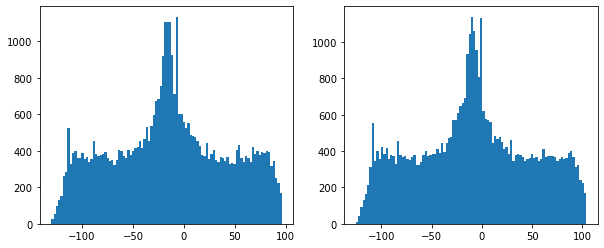

In [349]:
## Manual Adjustment
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.hist(p_z_Ar0_raw, bins = 100);
ax2.hist(p_z_Ar1_raw, bins = 100);


In [350]:
p_x_Ar0 = p_x_Ar0_raw
p_x_Ar1 = p_x_Ar1_raw
p_y_Ar0 = p_y_Ar0_raw
p_y_Ar1 = p_y_Ar1_raw
p_z_Ar0 = p_z_Ar0_raw
p_z_Ar1 = p_z_Ar1_raw

p_x_e0 = p_x_e0_raw
p_x_e1 = p_x_e1_raw
p_y_e0 = p_y_e0_raw
p_y_e1 = p_y_e1_raw
p_z_e0 = p_z_e0_raw
p_z_e1 = p_z_e1_raw

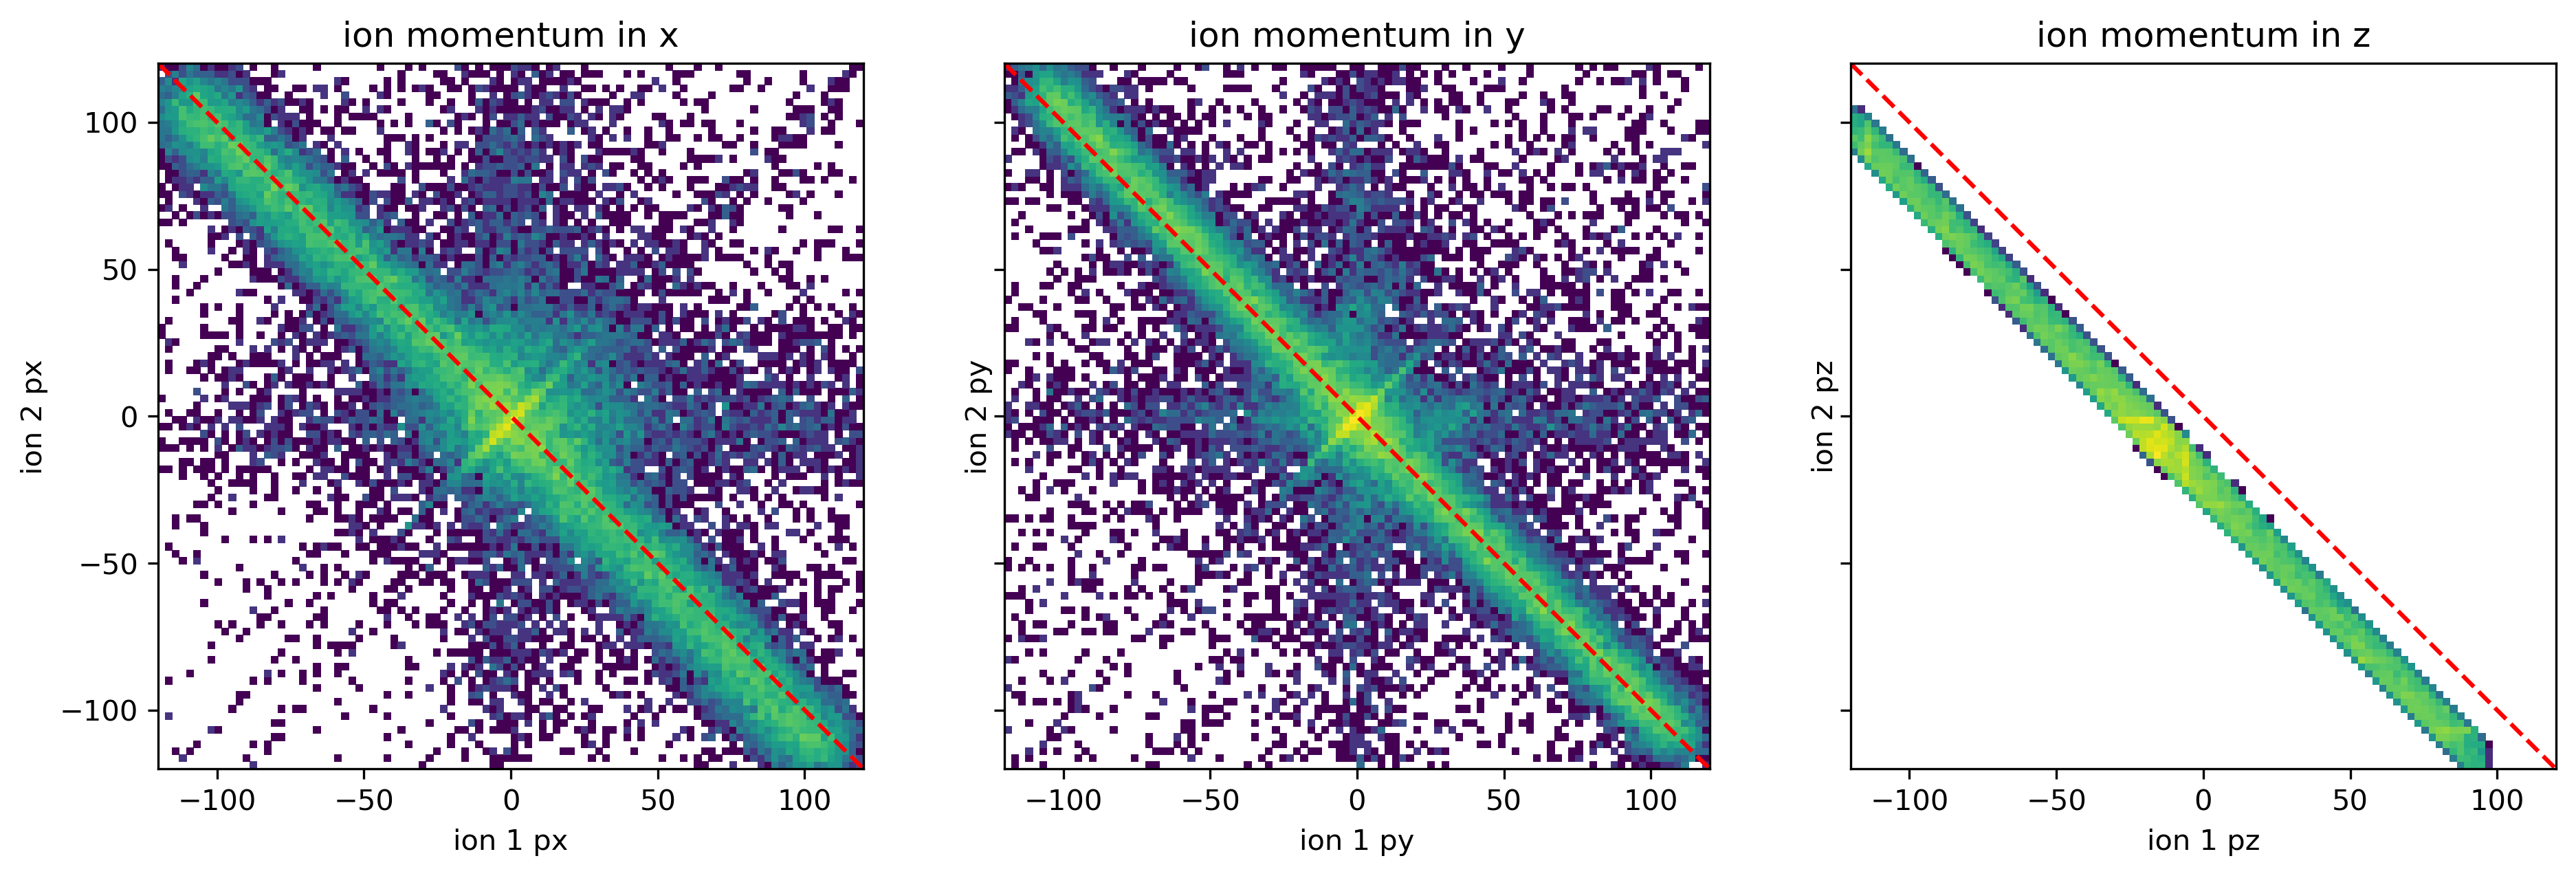

In [351]:
#######################################
#ION MOMENTUM PLOT###################
######################################
# Determine the data range
x_range = (-120, 120)
y_range = (-120, 120)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True,dpi=300)

# Plot the histograms
hist1 = axs[0].hist2d(p_x_Ar0, p_x_Ar1, bins=(100, 100), norm=LogNorm(), range=[x_range, y_range]);
axs[0].set_aspect('equal')
axs[0].set_title('ion momentum in x')
axs[0].set_xlabel('ion 1 px')
axs[0].set_ylabel('ion 2 px')


hist2 = axs[1].hist2d(p_y_Ar0, p_y_Ar1, bins=(100, 100), norm=LogNorm(), range=[x_range, y_range]);
axs[1].set_aspect('equal')
axs[1].set_title('ion momentum in y')
axs[1].set_xlabel('ion 1 py')
axs[1].set_ylabel('ion 2 py')

hist3 = axs[2].hist2d(p_z_Ar0, p_z_Ar1, bins=(100, 100), norm=LogNorm(), range=[x_range, y_range]);
axs[2].set_aspect('equal');
axs[2].set_title('ion momentum in z');
axs[2].set_xlabel('ion 1 pz');
axs[2].set_ylabel('ion 2 pz');

for ax in axs:
    ax.plot([x_range[0], x_range[1]], [y_range[1], y_range[0]], color='red', linestyle='--')

# Show the plot
plt.savefig(folder_path + "\\ion_mom_xx_yy_zz.png")

plt.show()



-14.268471710986374
-8.56365250366328
-11.416062107324827


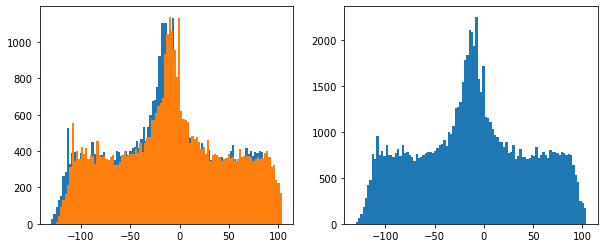

In [352]:
p_z0_mean = (sum(p_z_Ar0)/len(p_z_Ar0))
p_z1_mean = (sum(p_z_Ar1)/len(p_z_Ar1))
p_z_mean = (p_z0_mean+p_z1_mean)/2
#p_z_mean = 0
print(p_z0_mean)
print(p_z1_mean)

p_z_total = np.concatenate((p_z_Ar0, p_z_Ar1))
print(p_z_mean)
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.hist(p_z_Ar0, bins = 100);
ax1.hist(p_z_Ar1, bins = 100);
ax2.hist(p_z_total, bins = 100);
p_z_Ar0 = p_z_Ar0-p_z_mean
p_z_Ar1 = p_z_Ar1-p_z_mean

# mean = np.mean(p_z_e0)
# std_dev = np.std(p_z_e0)
# threshold = 3
# z_scores = np.abs((p_z_e0 - mean) / std_dev)
# outliers = p_z_e0[z_scores > threshold]
# cleaned_data = p_z_e0[z_scores <= threshold]
# mean_without_outliers = np.mean(cleaned_data)
# p_z_e0 = p_z_e0 - mean_without_outliers

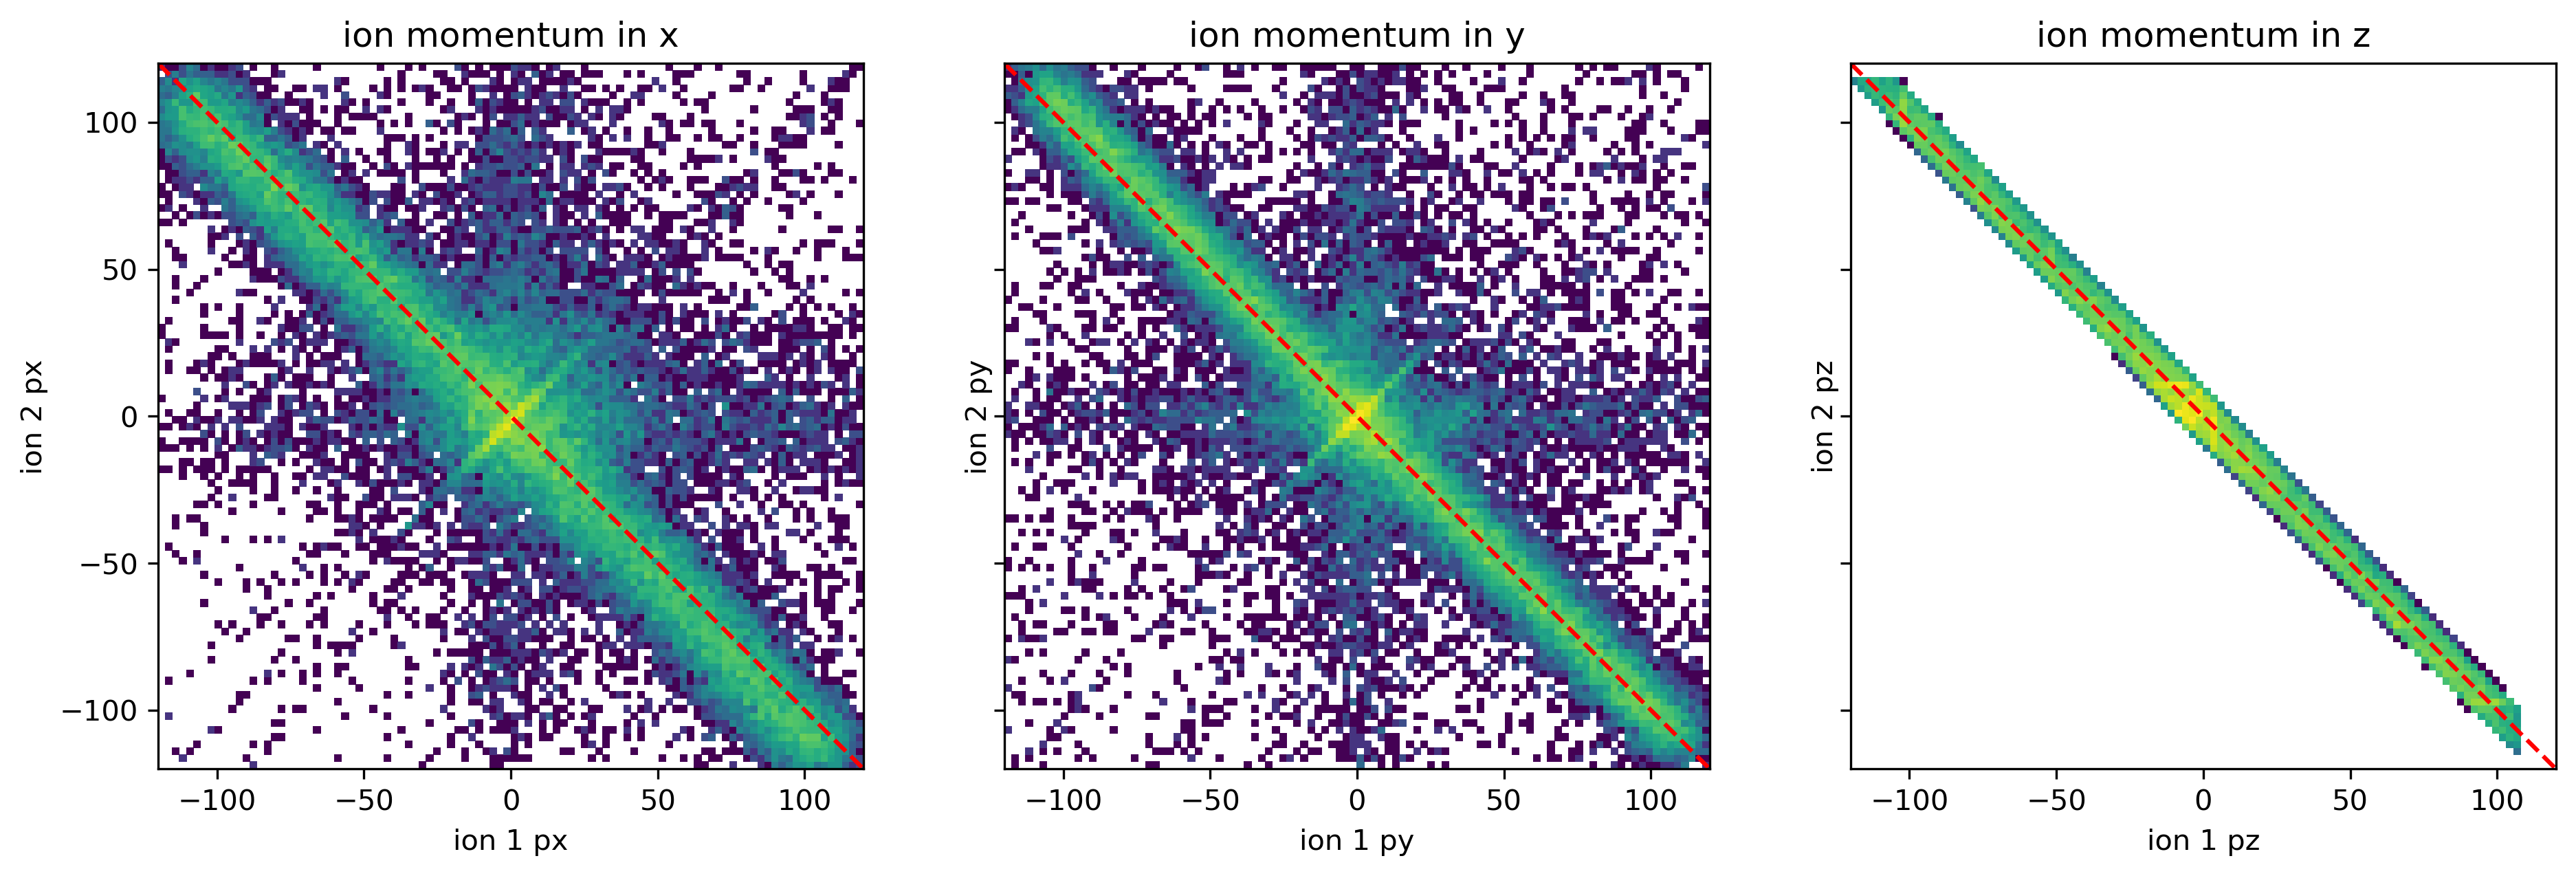

In [353]:
#######################################
#ION MOMENTUM PLOT###################
######################################
# Determine the data range
x_range = (-120, 120)
y_range = (-120, 120)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True,dpi=300)

# Plot the histograms
hist1 = axs[0].hist2d(p_x_Ar0, p_x_Ar1, bins=(100, 100), norm=LogNorm(), range=[x_range, y_range]);
axs[0].set_aspect('equal')
axs[0].set_title('ion momentum in x')
axs[0].set_xlabel('ion 1 px')
axs[0].set_ylabel('ion 2 px')


hist2 = axs[1].hist2d(p_y_Ar0, p_y_Ar1, bins=(100, 100), norm=LogNorm(), range=[x_range, y_range]);
axs[1].set_aspect('equal')
axs[1].set_title('ion momentum in y')
axs[1].set_xlabel('ion 1 py')
axs[1].set_ylabel('ion 2 py')

hist3 = axs[2].hist2d(p_z_Ar0, p_z_Ar1, bins=(100, 100), norm=LogNorm(), range=[x_range, y_range]);
axs[2].set_aspect('equal');
axs[2].set_title('ion momentum in z');
axs[2].set_xlabel('ion 1 pz');
axs[2].set_ylabel('ion 2 pz');

for ax in axs:
    ax.plot([x_range[0], x_range[1]], [y_range[1], y_range[0]], color='red', linestyle='--')

# Show the plot
plt.savefig(folder_path + "\\ion_mom_xx_yy_zz.png")

plt.show()



In [354]:
# #Center electron momentum

# mean = np.mean(p_x_Ar0)
# std_dev = np.std(p_x_Ar0)
# threshold = 1
# z_scores = np.abs((p_x_Ar0 - mean) / std_dev)
# outliers = p_x_Ar0[z_scores > threshold]
# cleaned_data = p_x_Ar0[z_scores <= threshold]
# mean_without_outliers = np.mean(cleaned_data)
# p_x_Ar0 = p_x_Ar0 - mean_without_outliers

# mean = np.mean(p_y_Ar0)
# std_dev = np.std(p_y_Ar0)
# threshold = 1
# z_scores = np.abs((p_y_Ar0 - mean) / std_dev)
# outliers = p_y_Ar0[z_scores > threshold]
# cleaned_data = p_y_Ar0[z_scores <= threshold]
# mean_without_outliers = np.mean(cleaned_data)
# p_y_Ar0 = p_y_Ar0 - mean_without_outliers

# if number_of_fragment == 1:
#     mean = np.mean(p_z_Ar0)
#     std_dev = np.std(p_z_Ar0)
#     threshold = 3
#     z_scores = np.abs((p_z_Ar0 - mean) / std_dev)
#     outliers = p_z_Ar0[z_scores > threshold]
#     cleaned_data = p_z_Ar0[z_scores <= threshold]
#     mean_without_outliers = np.mean(cleaned_data)
#     p_z_Ar0 = p_z_Ar0 - mean_without_outliers

# mean = np.mean(p_x_Ar1)
# std_dev = np.std(p_x_Ar1)
# threshold = 1
# z_scores = np.abs((p_x_Ar1 - mean) / std_dev)
# outliers = p_x_Ar1[z_scores > threshold]
# cleaned_data = p_x_Ar1[z_scores <= threshold]
# mean_without_outliers = np.mean(cleaned_data)
# p_x_Ar1 = p_x_Ar1 - mean_without_outliers

# mean = np.mean(p_y_Ar1)
# std_dev = np.std(p_y_Ar1)
# threshold = 1
# z_scores = np.abs((p_y_Ar1 - mean) / std_dev)
# outliers = p_y_Ar1[z_scores > threshold]
# cleaned_data = p_y_Ar1[z_scores <= threshold]
# mean_without_outliers = np.mean(cleaned_data)
# p_y_Ar1 = p_y_Ar1 - mean_without_outliers

# if number_of_fragment == 1:
#     mean = np.mean(p_z_Ar1)
#     std_dev = np.std(p_z_Ar1)
#     threshold = 3
#     z_scores = np.abs((p_z_Ar1 - mean) / std_dev)
#     outliers = p_z_Ar1[z_scores > threshold]
#     cleaned_data = p_z_Ar1[z_scores <= threshold]
#     mean_without_outliers = np.mean(cleaned_data)
#     p_z_Ar1 = p_z_Ar1 - mean_without_outliers



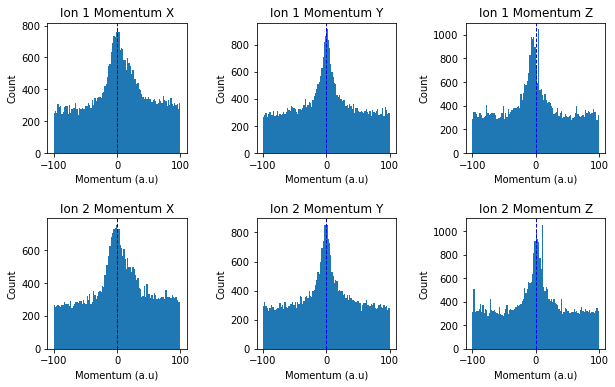

In [355]:
#######################################
#Ion MOMENTUM PLOT###################
######################################
fig, axes = plt.subplots(2,3,figsize=(10,6))
data = [p_x_Ar0, p_y_Ar0, p_z_Ar0, p_x_Ar1, p_y_Ar1, p_z_Ar1]

ranges = (-100,100)

axes[0,0].hist(p_x_Ar0, bins=(100), range=ranges);
axes[0,1].hist(p_y_Ar0, bins=(100), range=ranges);
axes[0,2].hist(p_z_Ar0, bins=(100), range=ranges);
axes[1,0].hist(p_x_Ar1, bins=(100), range=ranges);
axes[1,1].hist(p_y_Ar1, bins=(100), range=ranges);
axes[1,2].hist(p_z_Ar1, bins=(100), range=ranges);

axes[0, 0].set_title('Ion 1 Momentum X')
axes[0, 1].set_title('Ion 1 Momentum Y')
axes[0, 2].set_title('Ion 1 Momentum Z')
axes[1, 0].set_title('Ion 2 Momentum X')
axes[1, 1].set_title('Ion 2 Momentum Y')
axes[1, 2].set_title('Ion 2 Momentum Z')

axes[0, 0].set_xlabel('Momentum (a.u)')
axes[0, 1].set_xlabel('Momentum (a.u)')
axes[0, 2].set_xlabel('Momentum (a.u)')
axes[1, 0].set_xlabel('Momentum (a.u)')
axes[1, 1].set_xlabel('Momentum (a.u)')
axes[1, 2].set_xlabel('Momentum (a.u)')

axes[0, 0].set_ylabel('Count')
axes[0, 1].set_ylabel('Count')
axes[0, 2].set_ylabel('Count')
axes[1, 0].set_ylabel('Count')
axes[1, 1].set_ylabel('Count')
axes[1, 2].set_ylabel('Count')

plt.subplots_adjust(hspace=0.5, wspace=0.5)

for ax in axes.flatten():
    ax.axvline(0, color='blue', linestyle='--', linewidth=1)


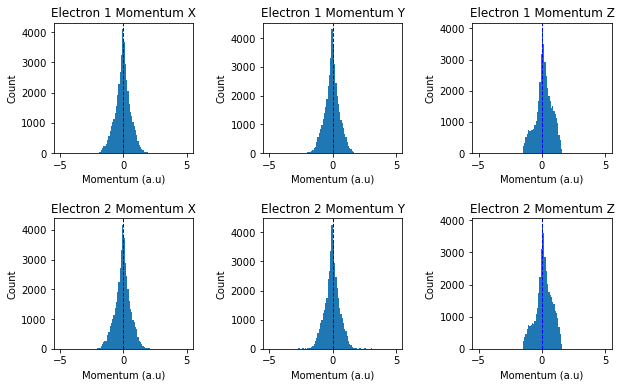

In [356]:
#######################################
#Electron MOMENTUM PLOT###################
######################################
fig, axes = plt.subplots(2,3,figsize=(10,6))
#data = [p_z_e1, p_z_e1, p_z_e1, p_z_e1, p_z_e1, p_z_e1]

ranges = (-5,5)

axes[0,0].hist(p_x_e0, bins=(100), range=ranges);
axes[0,1].hist(p_y_e0, bins=(100), range=ranges);
axes[0,2].hist(p_z_e0, bins=(100), range=ranges);
axes[1,0].hist(p_x_e1, bins=(100), range=ranges);
axes[1,1].hist(p_y_e1, bins=(100), range=ranges);
axes[1,2].hist(p_z_e1, bins=(100), range=ranges);

axes[0, 0].set_title('Electron 1 Momentum X')
axes[0, 1].set_title('Electron 1 Momentum Y')
axes[0, 2].set_title('Electron 1 Momentum Z')
axes[1, 0].set_title('Electron 2 Momentum X')
axes[1, 1].set_title('Electron 2 Momentum Y')
axes[1, 2].set_title('Electron 2 Momentum Z')

axes[0, 0].set_xlabel('Momentum (a.u)')
axes[0, 1].set_xlabel('Momentum (a.u)')
axes[0, 2].set_xlabel('Momentum (a.u)')
axes[1, 0].set_xlabel('Momentum (a.u)')
axes[1, 1].set_xlabel('Momentum (a.u)')
axes[1, 2].set_xlabel('Momentum (a.u)')

axes[0, 0].set_ylabel('Count')
axes[0, 1].set_ylabel('Count')
axes[0, 2].set_ylabel('Count')
axes[1, 0].set_ylabel('Count')
axes[1, 1].set_ylabel('Count')
axes[1, 2].set_ylabel('Count')

for ax in axes.flatten():
    #ax.set_aspect('equal')
    #ax.set_xlim(-120, 120)
    #ax.set_ylim(-120, 120)
    #ax.axhline(0, color='blue', linestyle='--', linewidth=1)
    ax.axvline(0, color='blue', linestyle='--', linewidth=1)
    #circle = Circle((0, 0), radius=90, color='red', fill=False, linestyle='dashed', linewidth=1)
    #ax.add_patch(circle)

#ax2.axvline(mu_i0_p_x1,c='r',ls='--')

plt.subplots_adjust(hspace=0.5, wspace=0.5)

In [357]:
#Center electron momentum

mean = np.mean(p_x_e0)
std_dev = np.std(p_x_e0)
threshold = 3
z_scores = np.abs((p_x_e0 - mean) / std_dev)
outliers = p_x_e0[z_scores > threshold]
cleaned_data = p_x_e0[z_scores <= threshold]
mean_without_outliers = np.mean(cleaned_data)
p_x_e0 = p_x_e0 - mean_without_outliers

mean = np.mean(p_y_e0)
std_dev = np.std(p_y_e0)
threshold = 3
z_scores = np.abs((p_y_e0 - mean) / std_dev)
outliers = p_y_e0[z_scores > threshold]
cleaned_data = p_y_e0[z_scores <= threshold]
mean_without_outliers = np.mean(cleaned_data)
p_y_e0 = p_y_e0 - mean_without_outliers

mean = np.mean(p_z_e0)
std_dev = np.std(p_z_e0)
threshold = 3
z_scores = np.abs((p_z_e0 - mean) / std_dev)
outliers = p_z_e0[z_scores > threshold]
cleaned_data = p_z_e0[z_scores <= threshold]
mean_without_outliers = np.mean(cleaned_data)
p_z_e0 = p_z_e0 - mean_without_outliers

mean = np.mean(p_x_e1)
std_dev = np.std(p_x_e1)
threshold = 3
z_scores = np.abs((p_x_e1 - mean) / std_dev)
outliers = p_x_e1[z_scores > threshold]
cleaned_data = p_x_e1[z_scores <= threshold]
mean_without_outliers = np.mean(cleaned_data)
p_x_e1 = p_x_e1 - mean_without_outliers

mean = np.mean(p_y_e1)
std_dev = np.std(p_y_e1)
threshold = 3
z_scores = np.abs((p_y_e1 - mean) / std_dev)
outliers = p_y_e1[z_scores > threshold]
cleaned_data = p_y_e1[z_scores <= threshold]
mean_without_outliers = np.mean(cleaned_data)
p_y_e1 = p_y_e1 - mean_without_outliers

mean = np.mean(p_z_e1)
std_dev = np.std(p_z_e1)
threshold = 3
z_scores = np.abs((p_z_e1 - mean) / std_dev)
outliers = p_z_e1[z_scores > threshold]
cleaned_data = p_z_e1[z_scores <= threshold]
mean_without_outliers = np.mean(cleaned_data)
p_z_e1 = p_z_e1 - mean_without_outliers



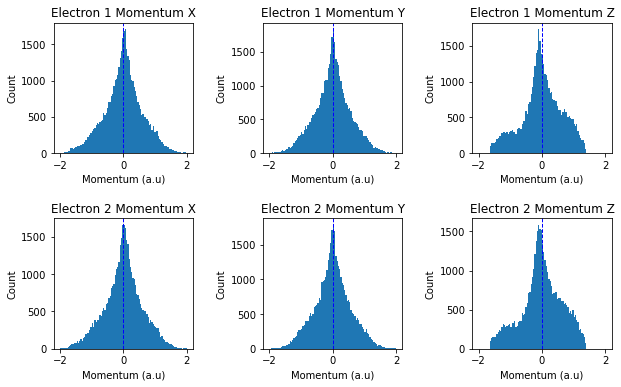

In [358]:
#######################################
#Electron MOMENTUM PLOT###################
######################################
fig, axes = plt.subplots(2,3,figsize=(10,6))
#data = [p_z_e1, p_z_e1, p_z_e1, p_z_e1, p_z_e1, p_z_e1]
xrange = (-2,2)

axes[0,0].hist(p_x_e0, bins=(100), range=xrange);
axes[0,1].hist(p_y_e0, bins=(100), range=xrange);
axes[0,2].hist(p_z_e0, bins=(100), range=xrange);
axes[1,0].hist(p_x_e1, bins=(100), range=xrange);
axes[1,1].hist(p_y_e1, bins=(100), range=xrange);
axes[1,2].hist(p_z_e1, bins=(100), range=xrange);

axes[0, 0].set_title('Electron 1 Momentum X')
axes[0, 1].set_title('Electron 1 Momentum Y')
axes[0, 2].set_title('Electron 1 Momentum Z')
axes[1, 0].set_title('Electron 2 Momentum X')
axes[1, 1].set_title('Electron 2 Momentum Y')
axes[1, 2].set_title('Electron 2 Momentum Z')

axes[0, 0].set_xlabel('Momentum (a.u)')
axes[0, 1].set_xlabel('Momentum (a.u)')
axes[0, 2].set_xlabel('Momentum (a.u)')
axes[1, 0].set_xlabel('Momentum (a.u)')
axes[1, 1].set_xlabel('Momentum (a.u)')
axes[1, 2].set_xlabel('Momentum (a.u)')

axes[0, 0].set_ylabel('Count')
axes[0, 1].set_ylabel('Count')
axes[0, 2].set_ylabel('Count')
axes[1, 0].set_ylabel('Count')
axes[1, 1].set_ylabel('Count')
axes[1, 2].set_ylabel('Count')

for ax in axes.flatten():
    #ax.set_aspect('equal')
    #ax.set_xlim(-120, 120)
    #ax.set_ylim(-120, 120)
    #ax.axhline(0, color='blue', linestyle='--', linewidth=1)
    ax.axvline(0, color='blue', linestyle='--', linewidth=1)
    #circle = Circle((0, 0), radius=90, color='red', fill=False, linestyle='dashed', linewidth=1)
    #ax.add_patch(circle)

#ax2.axvline(mu_i0_p_x1,c='r',ls='--')

plt.subplots_adjust(hspace=0.5, wspace=0.5)

In [359]:
###################################
# x is flipped looking at 2d spectra
# flip the x electron
####################################
p_x_e0 = -p_x_e0
p_x_e1 = -p_x_e1


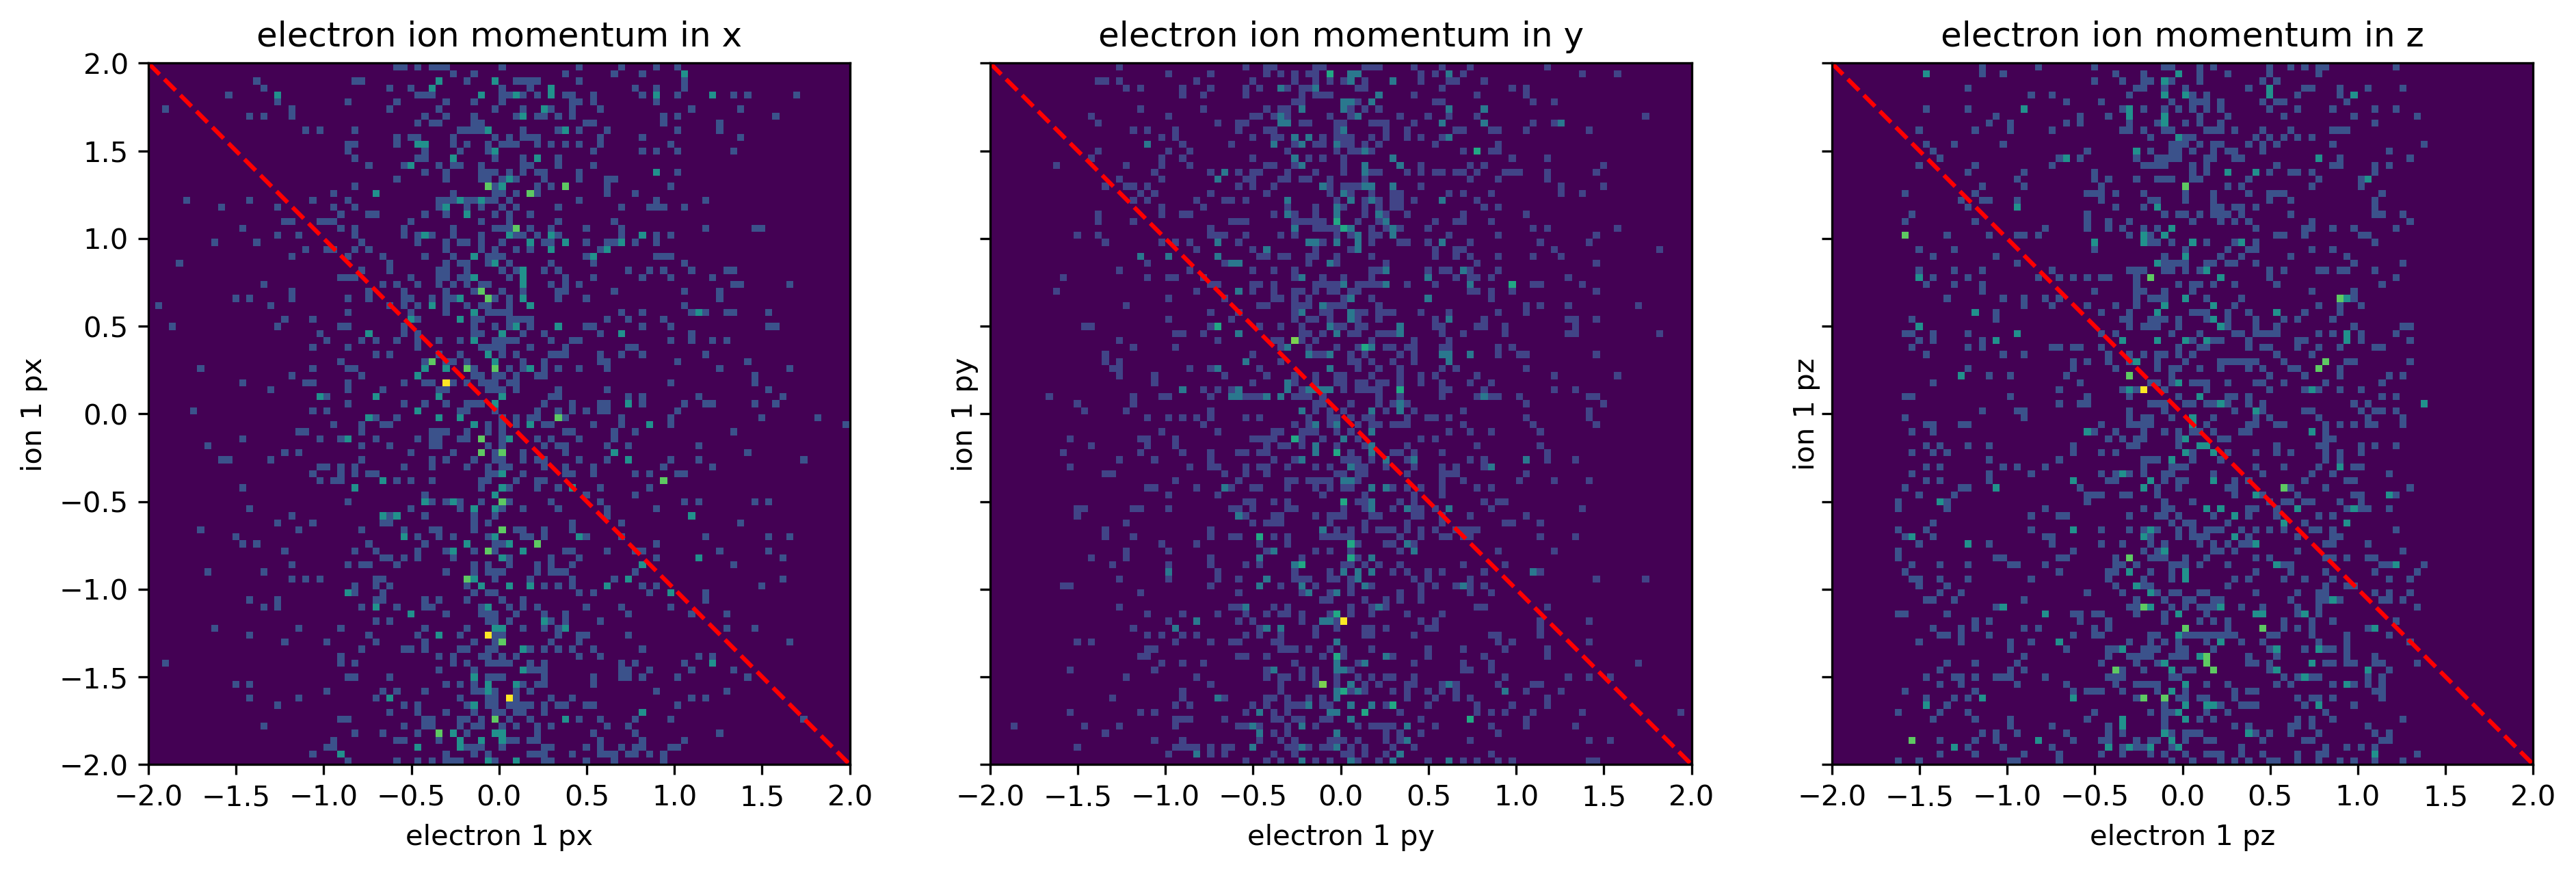

In [360]:
#######################################
#ION MOMENTUM PLOT###################
######################################

# Determine the data range
x_range = (-2, 2)
y_range = (-2, 2)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True,dpi=300)

# Plot the histograms
hist1 = axs[0].hist2d(p_x_e0, p_x_Ar0, bins=(100, 100), range=[x_range, y_range]);
axs[0].set_aspect('equal')
axs[0].set_title('electron ion momentum in x')
axs[0].set_xlabel('electron 1 px')
axs[0].set_ylabel('ion 1 px')


hist2 = axs[1].hist2d(p_y_e0, p_y_Ar0, bins=(100, 100), range=[x_range, y_range]);
axs[1].set_aspect('equal')
axs[1].set_title('electron ion momentum in y')
axs[1].set_xlabel('electron 1 py')
axs[1].set_ylabel('ion 1 py')

hist3 = axs[2].hist2d(p_z_e0, p_z_Ar0, bins=(100, 100), range=[x_range, y_range]);
axs[2].set_aspect('equal');
axs[2].set_title('electron ion momentum in z');
axs[2].set_xlabel('electron 1 pz');
axs[2].set_ylabel('ion 1 pz');

for ax in axs:
    ax.plot([x_range[0], x_range[1]], [y_range[1], y_range[0]], color='red', linestyle='--')

# Show the plot
plt.show()

## Write Momentum to File

In [361]:
# Define the file paths
if write_momentum_to_file:
# Define column titles

    data_dict = {
        "i_TOF0": i_TOF0,
        "i_x0": i_x0,
        "i_y0": i_y0,
        "i_TOF1": i_TOF1,
        "i_x1": i_x1,
        "i_y1": i_y1,
        "e_TOF0": e_TOF0,
        "e_x0": e_x0,
        "e_y0": e_y0,
        "e_TOF1": e_TOF1,
        "e_x1": e_x1,
        "e_y1": e_y1,
        "p_x_Ar0": p_x_Ar0,
        "p_y_Ar0": p_y_Ar0,
        "p_z_Ar0": p_z_Ar0,
        "p_x_Ar1": p_x_Ar1,
        "p_y_Ar1": p_y_Ar1,
        "p_z_Ar1": p_z_Ar1,
        "p_x_e0": p_x_e0,
        "p_y_e0": p_y_e0,
        "p_z_e0": p_z_e0,
        "p_x_e1": p_x_e1,
        "p_y_e1": p_y_e1,
        "p_z_e1": p_z_e1
    }

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(data_dict)

    # Define the output file path
    output_file = os.path.join(folder_path, output_file_name)

    # Write the DataFrame to a CSV file
    df.to_csv(output_file, index=False)

In [362]:
# e_X0 = calc_X0(e_TOF0, e_TOF1, e_x0, e_x1, 1/MASSAU, 1/MASSAU)
# e_Y0 = calc_Y0(e_TOF0, e_TOF1, e_y0, e_y1, 1/MASSAU, 1/MASSAU)
# e_px_X0 = calc_pxe_X0(e_TOF0, e_x0, e_y0, e_X0, e_Y0, B_field_ns, BField_clockwise=True)
# e_py_Y0 = calc_pye_Y0(e_TOF0, e_x0, e_y0, e_X0, e_Y0, B_field_ns, BField_clockwise=True)

In [363]:
# e_pz_Z0 = calc_pze_Z0(e_TOF0, e_acc1mm, e_acc2mm, e_acc3mm, e_Efield1_Vpcm, e_Efield2_Vpcm, e_Efield3_Vpcm)
# e_Z0 = calc_Z0e(e_TOF0, e_acc1mm, e_acc2mm, e_acc3mm, e_Efield1_Vpcm, e_Efield2_Vpcm, e_Efield3_Vpcm, 1, 1/MASSAU)

In [364]:
# # #//CM FRAME//
# cm_px1_X0 = calc_px_X0(i_TOF0, i_TOF1, i_x0, i_x1, m1, m2, q1, q2, B_field_ns, Bfield_clockwise);
# cm_py1_Y0 = calc_py_Y0(i_TOF0, i_TOF1, i_y0, i_y1, m1, m2, q1, q2, B_field_ns, Bfield_clockwise);
# cm_px2_X0 = calc_px_X0(i_TOF1, i_TOF0, i_x1, i_x0, m2, m1, q2, q1, B_field_ns, Bfield_clockwise);
# cm_py2_Y0 = calc_py_Y0(i_TOF1, i_TOF0, i_y1, i_y0, m2, m1, q2, q1, B_field_ns, Bfield_clockwise);
# cm_pz1_Z0 = calc_pz_Z0(i_TOF0, i_TOF1, m1, m2, q1, q2, l_acc1mm, l_acc2mm, l_acc3mm, l_Efield1_Vpcm, l_Efield2_Vpcm, l_Efield3_Vpcm);
# cm_pz2_Z0 = calc_pz_Z0(i_TOF1, i_TOF0, m2, m1, q2, q1, l_acc1mm, l_acc2mm, l_acc3mm, l_Efield1_Vpcm, l_Efield2_Vpcm, l_Efield3_Vpcm);
# cm_p1 = np.sqrt(cm_px1_X0*cm_px1_X0+cm_py1_Y0*cm_py1_Y0+cm_pz1_Z0*cm_pz1_Z0);
# cm_p2 = np.sqrt(cm_px2_X0*cm_px2_X0+cm_py2_Y0*cm_py2_Y0+cm_pz2_Z0*cm_pz2_Z0);
# cm_KE1 = cm_p1*cm_p1/(2*m1)/MASSAU*EVAU;
# cm_KE2 = cm_p2*cm_p2/(2*m2)/MASSAU*EVAU;
# cm_KER = cm_KE1+cm_KE2;
# cm_R12 = q1*q2*1.6*1e3/(4*PI*8.854*cm_KER)/0.529;

# cm_phi_x1_wi = np.arctan2(cm_pz1_Z0,cm_py1_Y0)/PI*180.;
# cm_phi_x2_wi = np.arctan2(cm_pz2_Z0,cm_py2_Y0)/PI*180.;
# cm_phi_y1_wi = np.arctan2(cm_px1_X0,cm_pz1_Z0)/PI*180.;
# cm_phi_y2_wi = np.arctan2(cm_px2_X0,cm_pz2_Z0)/PI*180.;
# cm_phi_z1_wi = np.arctan2(cm_py1_Y0,cm_px1_X0)/PI*180.;
# cm_phi_z2_wi = np.arctan2(cm_py2_Y0,cm_px2_X0)/PI*180.;
# cm_ctheta_x1_wi = (cm_px1_X0/cm_p1);
# cm_ctheta_x2_wi = (cm_px2_X0/cm_p2);
# cm_ctheta_y1_wi = (cm_py1_Y0/cm_p1);
# cm_ctheta_y2_wi = (cm_py2_Y0/cm_p2);
# cm_ctheta_z1_wi = (cm_pz1_Z0/cm_p1);
# cm_ctheta_z2_wi = (cm_pz2_Z0/cm_p2);
# cm_theta_x1_wi = np.arccos(cm_px1_X0/cm_p1)/PI*180.;
# cm_theta_x2_wi = np.arccos(cm_px2_X0/cm_p2)/PI*180.;
# cm_theta_y1_wi = np.arccos(cm_py1_Y0/cm_p1)/PI*180.;
# cm_theta_y2_wi = np.arccos(cm_py2_Y0/cm_p2)/PI*180.;
# cm_theta_z1_wi = np.arccos(cm_pz1_Z0/cm_p1)/PI*180.;
# cm_theta_z2_wi = np.arccos(cm_pz2_Z0/cm_p2)/PI*180.;

In [365]:
# plt.hist(cm_ctheta_z1_wi);